# H1N1 Cases to Predict NASDAQ

### Introduction

__With COVID-19 griping everyone's lives and finances we have all noticed the financial market dive and unemployment sky rocket. The question that everyone has is when will we bounce back and are we on that track yet?__

__More questions come from the volitiliy of the market, and the question on everyone's question in the financial world is, have we hit rock bottom? In order to analyze this question, I thought it was best to look back into past pandemics that gripped the world. Although the world has never seen such a deadily virus in modern history, I want to know if there is something from the past that can help us with our future.__

__I investigate Swine Flu, a respiratory disease of pigs caused by type A influenza virus. When this virs is detected in a person, it is called Variant Influenza Virus as was seen in the 2009 Influenza Pandemic. MOst commonly, human infections with variant viruses occur in people with exposure to infected pigs. The virus can also be trransmitted through direct contact of an infected surface or person and then touching your face. The third way of transmission is through the air in droplets or dust. The United States of America faced the virus since 2009.__

In this analysis I have used __XGBoost__ as my machine learning model, and measured my accuracy with mean squared error and mean absolute error. __XGBoost__ is an optimized distributed gradient boosting library to be highly efficient, flexible, and portable. It implements machine learning under the __Gradient Boosting__ framework, as it provides a parallel tree boosting to solve data science problems in a fast and accurate way.

__Gradient boosting__ is a method that goes through cycles to iteratively add models into an ensemble. It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. However, subsequent additions to the ensemble will address those errors.

__Steps of Gradient Boosting:__
    - First use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble
    - The predictions are then used to calculate a loss function, which are my error values
    - Next we use the loss function to fit a new model that will be added to the ensemble. Specifically, I determined model parameters so that adding this new model to the ensemble will reduce the loss
    - Finally, we add the new model to ensemble and repeat until we have an accurate model.
    
__XGBoost Parameters:__
    - n_estimators -> Specifies how many times to go through the modeling cycle
    - max_depth -> Maximum depth of a tree, large value can cause overfitting
    - learning_rate -> Shrinkage factor that avoids overfitting of the model
    - subsample -> Subsample ratio of the training instances, it will occur once in every boosting iteration
    - colsample_bytree -> Subsample ratio of columns when constructing each tree
    - colsample_bylevel -> Subsample ratio of columns for each level
    - gamma -> Minimum loss reduction required to make a futher partition of a leaf node of the tree

#### Import Necessary Libraries

In [54]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

%matplotlib notebook
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import Common_Functions as cf
import time
import mplcursors

from matplotlib.backends.backend_agg import FigureCanvasAgg 
plt.get_backend()

test_size = 0.2
valid_size = 0.2
N = 21

n_estimators = 100
max_depth = 3
learning_rate = 0.1
min_child_weight = 1
subsample = 1
colsample_bytree = 1
colsample_bylevel = 1
gamma = 0
model_seed = 100

style.use('seaborn-darkgrid')

### Load and Format Dataset

The dataset has already been merged on the dates of Swine Flu cases dates, with the cases summed up per date, and the OHLC data along with cases. I have taken the dataset and formatted it for greater readability and analysis. The dates column is changed into datetime data type.

In [55]:
SWINE_IXIC = pd.read_csv('SWINE_IXIC.csv', parse_dates = True, index_col = 0)
SWINE_IXIC.head()

,season,year,week,age_0_4,age_5_24,age_25_49,age_25_64,age_50_64,age_65,ilitotal,...,num_of_providers,unweighted_ili,weighted_ili,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-09,2009,1,3245,2548,NaN,2606.0,NaN,557,8956,...,1539,0.015457,0.014714,2009-01-08,1590.250000,1617.010010,1584.280029,1617.010010,1617.010010,1968160000
1,2008-09,2009,2,3142,3345,NaN,2329.0,NaN,473,9289,...,1512,0.016422,0.016155,2009-01-15,1489.459961,1521.579956,1456.719971,1511.839966,1511.839966,2507870000
2,2008-09,2009,3,3602,4597,NaN,2821.0,NaN,436,11456,...,1566,0.019652,0.019533,2009-01-22,1470.849976,1492.469971,1444.079956,1465.489990,1465.489990,2286190000
3,2008-09,2009,4,4039,6602,NaN,3215.0,NaN,468,14324,...,1554,0.023437,0.024291,2009-01-29,1537.469971,1537.839966,1505.699951,1507.839966,1507.839966,1932100000
4,2008-09,2009,5,4606,8882,NaN,4240.0,NaN,540,18268,...,1580,0.028606,0.029669,2009-02-05,1498.589966,1554.369995,1495.520020,1546.239990,1546.239990,2511750000


In [56]:
SWINE_IXIC.columns = [str(col).upper().replace(' ', '_') for col in SWINE_IXIC.columns]
SWINE_IXIC.head()

,SEASON,YEAR,WEEK,AGE_0_4,AGE_5_24,AGE_25_49,AGE_25_64,AGE_50_64,AGE_65,ILITOTAL,...,NUM_OF_PROVIDERS,UNWEIGHTED_ILI,WEIGHTED_ILI,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME
0,2008-09,2009,1,3245,2548,NaN,2606.0,NaN,557,8956,...,1539,0.015457,0.014714,2009-01-08,1590.250000,1617.010010,1584.280029,1617.010010,1617.010010,1968160000
1,2008-09,2009,2,3142,3345,NaN,2329.0,NaN,473,9289,...,1512,0.016422,0.016155,2009-01-15,1489.459961,1521.579956,1456.719971,1511.839966,1511.839966,2507870000
2,2008-09,2009,3,3602,4597,NaN,2821.0,NaN,436,11456,...,1566,0.019652,0.019533,2009-01-22,1470.849976,1492.469971,1444.079956,1465.489990,1465.489990,2286190000
3,2008-09,2009,4,4039,6602,NaN,3215.0,NaN,468,14324,...,1554,0.023437,0.024291,2009-01-29,1537.469971,1537.839966,1505.699951,1507.839966,1507.839966,1932100000
4,2008-09,2009,5,4606,8882,NaN,4240.0,NaN,540,18268,...,1580,0.028606,0.029669,2009-02-05,1498.589966,1554.369995,1495.520020,1546.239990,1546.239990,2511750000


In [57]:
SWINE_IXIC = SWINE_IXIC.rename(columns = {'ILITOTAL':'CASES'})
SWINE_IXIC = SWINE_IXIC.drop(['SEASON', 'YEAR', 'WEEK', 'AGE_0_4', 'AGE_5_24', 'AGE_25_49', 'AGE_25_64', 'AGE_50_64', 'AGE_65', 'TOTAL_PATIENTS', 'NUM_OF_PROVIDERS', 'UNWEIGHTED_ILI', 'WEIGHTED_ILI'], axis = 1)
SWINE_IXIC.head()

,CASES,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME
0,8956,2009-01-08,1590.250000,1617.010010,1584.280029,1617.010010,1617.010010,1968160000
1,9289,2009-01-15,1489.459961,1521.579956,1456.719971,1511.839966,1511.839966,2507870000
2,11456,2009-01-22,1470.849976,1492.469971,1444.079956,1465.489990,1465.489990,2286190000
3,14324,2009-01-29,1537.469971,1537.839966,1505.699951,1507.839966,1507.839966,1932100000
4,18268,2009-02-05,1498.589966,1554.369995,1495.520020,1546.239990,1546.239990,2511750000


In [58]:
SWINE_IXIC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CASES      101 non-null    int64  
 1   DATE       101 non-null    object 
 2   OPEN       101 non-null    float64
 3   HIGH       101 non-null    float64
 4   LOW        101 non-null    float64
 5   CLOSE      101 non-null    float64
 6   ADJ_CLOSE  101 non-null    float64
 7   VOLUME     101 non-null    int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.1+ KB


In [59]:
SWINE_IXIC.loc[:, 'DATE'] = pd.to_datetime(SWINE_IXIC['DATE'], format = '%Y-%m-%d')

In [60]:
SWINE_IXIC.dtypes

CASES                 int64
DATE         datetime64[ns]
OPEN                float64
HIGH                float64
LOW                 float64
CLOSE               float64
ADJ_CLOSE           float64
VOLUME                int64
dtype: object

### Graphing Adjusted Close and Volume of NASDAQ

I have graphed the adjusted close and volume of IXIC over time and we can see a drop in the price right before 04/2009 with an increase of volume of shares during the same period as more people went short on their stocks of companies in the NASDAQ.

<IPython.core.display.Javascript object>


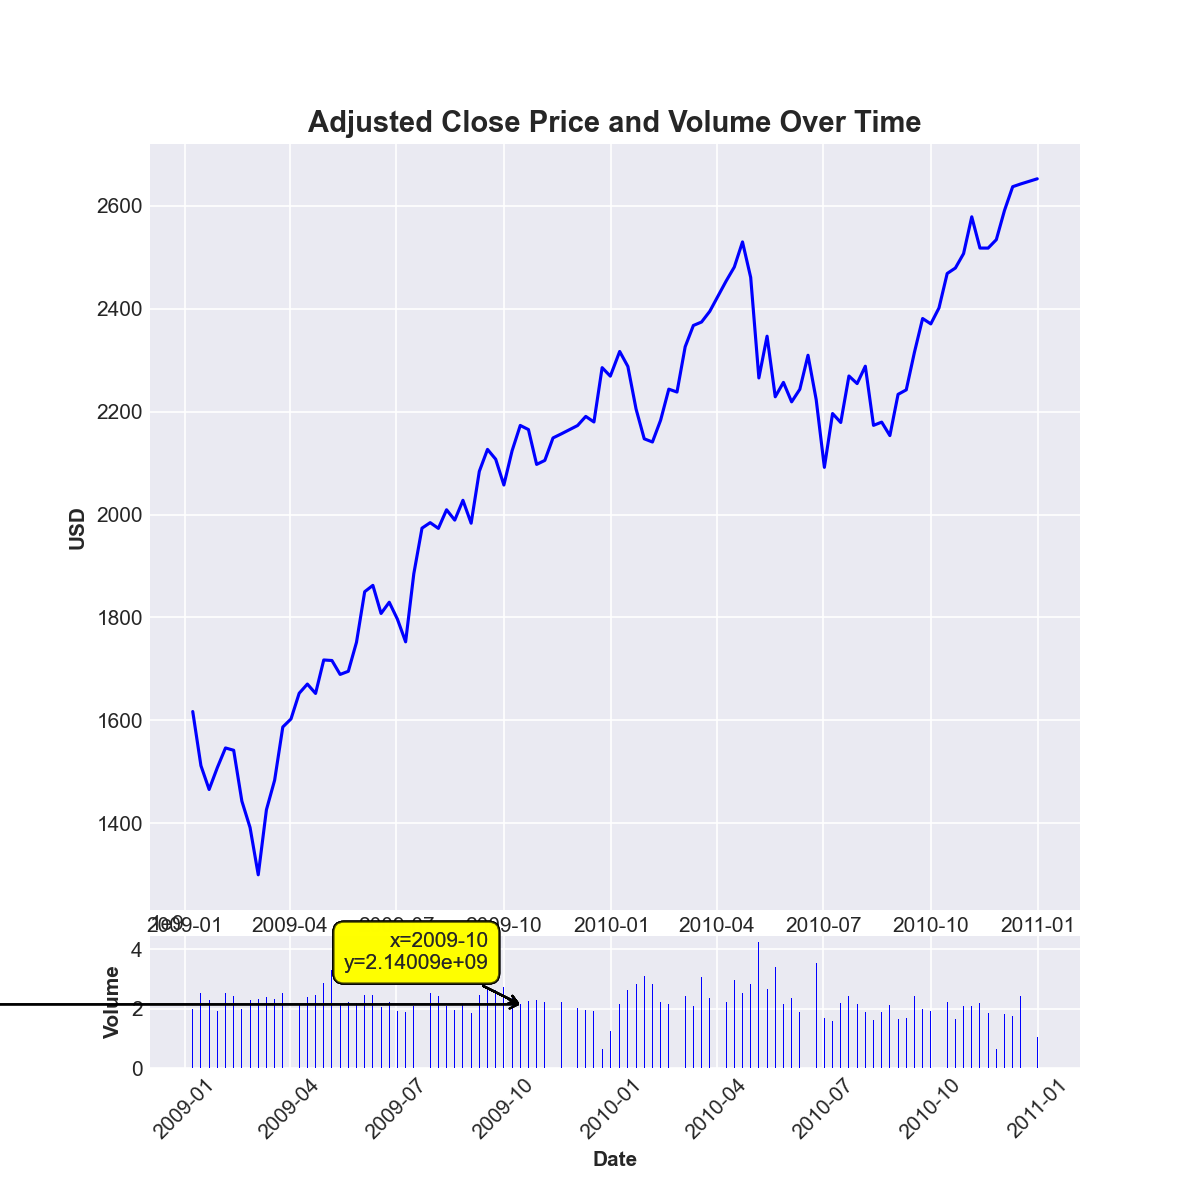

In [61]:
rcParams['figure.figsize'] = 8, 8

plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 1, colspan = 1, sharex = ax1)

ax1.plot(SWINE_IXIC['DATE'], SWINE_IXIC['ADJ_CLOSE'], 'b-')
ax1.set_ylabel('USD', fontweight = 'bold')
ax1.set_title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
ax1.grid(True)

ax2.bar(SWINE_IXIC['DATE'], SWINE_IXIC['VOLUME'], color = 'blue')
ax2.grid(True)
ax2.set_ylabel('Volume', fontweight = 'bold')

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

### Feature Engineering

For better analysis I have added the range of high and low as well as range of open and close of the prices each day. Lag columns are created for the past 21 days allowing constant feed of data into the XGBoost model for better predictions. The mean and standard deviation of columns is also calculated to help with scaling in the next steps.

In [62]:
SWINE_IXIC['RANGE_HL'] = SWINE_IXIC['HIGH'] - SWINE_IXIC['LOW']
SWINE_IXIC['RANGE_OC'] = SWINE_IXIC['OPEN'] - SWINE_IXIC['CLOSE']
SWINE_IXIC.head()

,CASES,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,RANGE_HL,RANGE_OC
0,8956,2009-01-08,1590.250000,1617.010010,1584.280029,1617.010010,1617.010010,1968160000,32.729981,-26.760010
1,9289,2009-01-15,1489.459961,1521.579956,1456.719971,1511.839966,1511.839966,2507870000,64.859985,-22.380005
2,11456,2009-01-22,1470.849976,1492.469971,1444.079956,1465.489990,1465.489990,2286190000,48.390015,5.359986
3,14324,2009-01-29,1537.469971,1537.839966,1505.699951,1507.839966,1507.839966,1932100000,32.140015,29.630005
4,18268,2009-02-05,1498.589966,1554.369995,1495.520020,1546.239990,1546.239990,2511750000,58.849975,-47.650024


In [63]:
SWINE_IXIC['ORDER'] = [idx for idx in list(range(len(SWINE_IXIC)))]

merging_keys = ['ORDER']

lag_cols = ['CASES', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']
lag_cols

['CASES',
 'OPEN',
 'HIGH',
 'LOW',
 'CLOSE',
 'ADJ_CLOSE',
 'VOLUME',
 'RANGE_HL',
 'RANGE_OC']

In [64]:
days_lagging = [day+1 for day in range(N)]

for lag in tqdm_notebook(days_lagging):
    train_lag = SWINE_IXIC[merging_keys + lag_cols].copy()
    
    train_lag['ORDER'] = train_lag['ORDER'] + lag
    
    foo = lambda num: '{}_LAG_{}'.format(num, lag) if num in lag_cols else num
    train_lag = train_lag.rename(columns = foo)
    
    SWINE_IXIC = pd.merge(SWINE_IXIC, train_lag, on = merging_keys, how = 'left')
    
del train_lag

SWINE_IXIC = SWINE_IXIC[N:]

SWINE_IXIC.head()

<ipython-input-64-a5ebcf991a8a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lag in tqdm_notebook(days_lagging):


,CASES,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,RANGE_HL,RANGE_OC,...,RANGE_OC_LAG_20,CASES_LAG_21,OPEN_LAG_21,HIGH_LAG_21,LOW_LAG_21,CLOSE_LAG_21,ADJ_CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21
21,17105,2009-06-04,1829.839966,1850.040039,1825.619995,1850.020020,1850.020020,2468840000,24.420044,-20.180054,...,-22.380005,8956.0,1590.250000,1617.010010,1584.280029,1617.010010,1617.010010,1.968160e+09,32.729981,-26.760010
22,12392,2009-06-11,1854.750000,1879.920044,1854.750000,1862.369995,1862.369995,2463860000,25.170044,-7.619995,...,5.359986,9289.0,1489.459961,1521.579956,1456.719971,1511.839966,1511.839966,2.507870e+09,64.859985,-22.380005
23,10780,2009-06-18,1809.040039,1816.599976,1795.739990,1807.719971,1807.719971,2067830000,20.859986,1.320068,...,29.630005,11456.0,1470.849976,1492.469971,1444.079956,1465.489990,1465.489990,2.286190e+09,48.390015,5.359986
24,8801,2009-06-25,1783.189941,1829.670044,1779.180054,1829.540039,1829.540039,2227980000,50.489990,-46.350098,...,-47.650024,14324.0,1537.469971,1537.839966,1505.699951,1507.839966,1507.839966,1.932100e+09,32.140015,29.630005
25,7422,2009-07-02,1823.689941,1823.910034,1795.949951,1796.520020,1796.520020,1923070000,27.960083,27.169921,...,-31.539917,18268.0,1498.589966,1554.369995,1495.520020,1546.239990,1546.239990,2.511750e+09,58.849975,-47.650024


In [65]:
SWINE_IXIC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 21 to 100
Columns: 200 entries, CASES to RANGE_OC_LAG_21
dtypes: datetime64[ns](1), float64(196), int64(3)
memory usage: 125.6 KB


In [66]:
for col in lag_cols:
    SWINE_IXIC = cf.get_mov_avg_std(SWINE_IXIC, col)
    
SWINE_IXIC.head()

,CASES,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,RANGE_HL,RANGE_OC,...,CLOSE_MEAN,CLOSE_STD,ADJ_CLOSE_MEAN,ADJ_CLOSE_STD,VOLUME_MEAN,VOLUME_STD,RANGE_HL_MEAN,RANGE_HL_STD,RANGE_OC_MEAN,RANGE_OC_STD
21,17105,2009-06-04,1829.839966,1850.040039,1825.619995,1850.020020,1850.020020,2468840000,24.420044,-20.180054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,12392,2009-06-11,1854.750000,1879.920044,1854.750000,1862.369995,1862.369995,2463860000,25.170044,-7.619995,...,1850.020020,NaN,1850.020020,NaN,2.468840e+09,NaN,24.420044,NaN,-20.180054,NaN
23,10780,2009-06-18,1809.040039,1816.599976,1795.739990,1807.719971,1807.719971,2067830000,20.859986,1.320068,...,1856.195007,8.732751,1856.195007,8.732751,2.466350e+09,3.521392e+06,24.795044,0.530330,-13.900024,8.881303
24,8801,2009-06-25,1783.189941,1829.670044,1779.180054,1829.540039,1829.540039,2227980000,50.489990,-46.350098,...,1840.036662,28.660196,1840.036662,28.660196,2.333510e+09,2.300991e+08,23.483358,2.302647,-8.826660,10.800733
25,7422,2009-07-02,1823.689941,1823.910034,1795.949951,1796.520020,1796.520020,1923070000,27.960083,27.169921,...,1837.412506,23.982271,1837.412506,23.982271,2.307128e+09,1.951441e+08,30.235016,13.633574,-18.207520,20.730959


### Splitting Train, Validation, and Test Dataset

I have used 60% of the data for training on, then 20% to validate and tune, finally the last 20% for testing the optimized XGBoost model

In [67]:
valid_len = int(valid_size * len(SWINE_IXIC))
test_len = int(test_size * len(SWINE_IXIC))
train_len = len(SWINE_IXIC) - (valid_len + test_len)
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))
print('Valid Set Len: ' + str(valid_len))

train = SWINE_IXIC[:train_len]
valid = SWINE_IXIC[train_len:(train_len + valid_len)]
test = SWINE_IXIC[(train_len + valid_len):]
print('Train Set Shape: ' + str(train.shape))
print('Valid Set Shape: ' + str(valid.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 48
Test Set Len: 16
Valid Set Len: 16
Train Set Shape: (48, 218)
Valid Set Shape: (16, 218)
Test Set Shape: (16, 218)


### Scaling Data

When looking at time-series stock data, the prices of stocks overall goes up, therefore the later dates will have a higher stock price compared to the earlier stock prices. In order to have a levled analysis I have scaled all of the data across the entire dataframe, this evens out the playing field for analysis. Also the unnecessary data columns were removed allowing for better readability while implementing XGBoost.

In [68]:
scaling_cols = ['ADJ_CLOSE']

for num in range(1, N+1):
    scaling_cols.append('CASES_LAG_'+str(num))
    scaling_cols.append('OPEN_LAG_'+str(num))
    scaling_cols.append('HIGH_LAG_'+str(num))
    scaling_cols.append('LOW_LAG_'+str(num))
    scaling_cols.append('ADJ_CLOSE_LAG_'+str(num))
    scaling_cols.append('VOLUME_LAG_'+str(num))
    scaling_cols.append('RANGE_HL_LAG_'+str(num))
    scaling_cols.append('RANGE_OC_LAG_'+str(num))
    
scaler = StandardScaler()
train_scale = scaler.fit_transform(train[scaling_cols])
train_df_scaled = pd.DataFrame(train_scale, columns = scaling_cols)
train_df_scaled[['DATE']] = train.reset_index()[['DATE']]
train_df_scaled

,ADJ_CLOSE,CASES_LAG_1,OPEN_LAG_1,HIGH_LAG_1,LOW_LAG_1,ADJ_CLOSE_LAG_1,VOLUME_LAG_1,RANGE_HL_LAG_1,RANGE_OC_LAG_1,CASES_LAG_2,...,RANGE_OC_LAG_20,CASES_LAG_21,OPEN_LAG_21,HIGH_LAG_21,LOW_LAG_21,ADJ_CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21,DATE
0,-1.550351,0.180820,-1.920886,-1.970225,-2.015425,-1.943633,-0.280445,0.461587,-0.389465,0.061293,...,-0.739383,-0.697154,-0.886588,-0.871406,-0.829894,-0.800034,-1.162312,-0.355898,-0.865419,2009-06-04
1,-1.485339,-0.155029,-1.499212,-1.493588,-1.455912,-1.441660,0.265847,-0.556991,-0.899256,0.164760,...,0.278202,-0.676040,-1.279210,-1.249769,-1.322238,-1.212689,0.636983,2.041576,-0.705469,2009-06-11
2,-1.773023,-0.454302,-1.376517,-1.343816,-1.309262,-1.378549,0.256122,-0.509394,-0.391886,-0.173042,...,1.168497,-0.538640,-1.351704,-1.365185,-1.371025,-1.394553,-0.102058,0.812621,0.307543,2009-06-18
3,-1.658160,-0.556663,-1.601663,-1.661206,-1.606337,-1.657821,-0.517239,-0.782924,-0.030748,-0.474055,...,-1.666361,-0.356792,-1.092190,-1.185301,-1.133190,-1.228384,-1.282529,-0.399920,1.193839,2009-06-25
4,-1.831981,-0.682329,-1.728988,-1.595692,-1.689705,-1.546316,-0.204501,1.097488,-1.956408,-0.577012,...,-1.075395,-0.106720,-1.243644,-1.119763,-1.172481,-1.077714,0.649918,1.593122,-1.628284,2009-07-02
5,-2.063445,-0.769895,-1.529504,-1.624564,-1.605280,-1.715054,-0.799924,-0.332330,1.013470,-0.703408,...,1.392267,0.108796,-1.198535,-1.166785,-1.173176,-1.095489,0.371544,0.721590,-1.039972,2009-07-09
6,-1.366053,-0.841776,-1.858135,-1.926716,-1.849494,-1.939749,-0.906917,-1.079291,0.094472,-0.791483,...,1.746253,0.004494,-1.321709,-1.394247,-1.377007,-1.483503,-1.086167,0.381328,1.416604,2009-07-16
7,-0.899810,-0.862477,-1.370114,-1.303866,-1.309514,-1.262752,-0.507671,-0.000419,-1.254733,-0.863783,...,1.284417,0.031632,-1.484149,-1.554069,-1.574084,-1.684985,-0.049384,1.183470,1.769000,2009-07-23
8,-0.843483,-0.877019,-1.030697,-0.845476,-0.956759,-0.810144,1.344936,1.356415,-2.048910,-0.884604,...,-2.057765,-0.095751,-1.891105,-1.958362,-1.933576,-2.045494,0.030128,0.524597,1.309238,2009-07-30
9,-0.902126,-0.886416,-0.729009,-0.692745,-0.678312,-0.755464,0.376824,-0.219999,-0.006921,-0.899230,...,1.019934,-0.268848,-1.753207,-1.622581,-1.714654,-1.549107,0.253260,2.611658,-2.017929,2009-08-06


In [69]:
valid_df_scaled = valid[['DATE']]
for col in tqdm_notebook(lag_cols):
    feat_list = [col + '_LAG_' + str(shift) for shift in range(1, N+1)]
    temp = valid.apply(lambda row: cf.scale_row(row[feat_list], row[col+'_MEAN'], row[col+'_STD']), axis = 1)
    valid_df_scaled = pd.concat([valid_df_scaled, temp], axis = 1)
        
    
valid_df_scaled.head()

<ipython-input-69-d95a67c972b6>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(lag_cols):


,DATE,CASES_LAG_1,CASES_LAG_2,CASES_LAG_3,CASES_LAG_4,CASES_LAG_5,CASES_LAG_6,CASES_LAG_7,CASES_LAG_8,CASES_LAG_9,...,RANGE_OC_LAG_12,RANGE_OC_LAG_13,RANGE_OC_LAG_14,RANGE_OC_LAG_15,RANGE_OC_LAG_16,RANGE_OC_LAG_17,RANGE_OC_LAG_18,RANGE_OC_LAG_19,RANGE_OC_LAG_20,RANGE_OC_LAG_21
69,2010-05-21,-1.243436,-0.749069,0.449259,0.271560,1.271686,1.299024,6.716559,9.928807,13.922474,...,-1.437491,-2.047004,-1.384116,1.010510,0.992984,0.137279,-2.010746,-0.070670,-1.485294,-0.481794
70,2010-05-28,-1.049704,-0.803147,-0.233967,1.145704,0.941114,2.092589,2.124065,8.361439,12.059798,...,-0.276879,-0.423986,-0.758919,-0.394655,0.921214,0.911583,0.441365,-0.738995,0.327095,-0.450254
71,2010-06-04,-1.476756,-0.171279,-0.007659,0.370059,1.285634,1.149864,1.914003,1.934891,6.074123,...,-0.866930,-0.442831,-0.596715,-0.947079,-0.566034,0.810458,0.800383,0.308503,-0.926237,0.188968
72,2010-06-11,-1.284623,-0.835161,0.471412,0.635169,1.013204,1.929547,1.793663,2.558444,2.579349,...,-0.117732,-0.852988,-0.410164,-0.570842,-0.936675,-0.538806,0.898463,0.887944,0.374344,-0.914913
73,2010-06-18,-1.438852,-0.383828,-0.059785,0.882201,1.000264,1.272811,1.933458,1.835491,2.386867,...,0.470538,0.281966,-0.410003,0.006751,-0.144468,-0.488763,-0.114318,1.238334,1.228434,0.745072


In [70]:
test_df_scaled = test[['DATE']]
for col in tqdm_notebook(lag_cols):
    feat_list = [col + '_LAG_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: cf.scale_row(row[feat_list], row[col+'_MEAN'], row[col+'_STD']), axis = 1)
    test_df_scaled = pd.concat([test_df_scaled, temp], axis = 1)
        
    
test_df_scaled.head()

<ipython-input-70-3ce69a9aa9d0>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(lag_cols):


,DATE,CASES_LAG_1,CASES_LAG_2,CASES_LAG_3,CASES_LAG_4,CASES_LAG_5,CASES_LAG_6,CASES_LAG_7,CASES_LAG_8,CASES_LAG_9,...,RANGE_OC_LAG_12,RANGE_OC_LAG_13,RANGE_OC_LAG_14,RANGE_OC_LAG_15,RANGE_OC_LAG_16,RANGE_OC_LAG_17,RANGE_OC_LAG_18,RANGE_OC_LAG_19,RANGE_OC_LAG_20,RANGE_OC_LAG_21
85,2010-09-10,1.501813,0.034984,0.279872,-0.994545,-0.822124,-1.389364,-1.139478,-0.429803,0.712174,...,0.644301,-2.855006,3.772213,2.179182,-4.087090,2.896149,4.191252,4.653895,-0.521570,2.661201
86,2010-09-17,1.403013,0.554712,-0.469882,-0.298825,-1.189018,-1.068580,-1.464803,-1.290255,-0.794540,...,0.631386,0.428292,-3.743127,4.156981,2.257977,-5.211857,3.112652,4.656506,5.208008,-0.961507
87,2010-09-24,1.005531,0.972683,0.033621,-1.100596,-0.911238,-1.896673,-1.763350,-2.201965,-2.008742,...,2.499798,0.971465,0.712641,-4.603432,5.464498,3.044399,-6.475187,4.133600,6.101093,6.803930
88,2010-10-01,1.527395,0.088595,0.068726,-0.499314,-1.185402,-1.070859,-1.666950,-1.586303,-1.851621,...,-1.041598,2.057000,0.983350,0.801526,-2.933002,4.139695,2.439581,-4.247906,3.204743,4.586902
89,2010-10-08,0.784579,1.281078,-0.445446,-0.469289,-1.150922,-1.974211,-1.836763,-2.552057,-2.455282,...,3.740135,-1.288648,1.125383,0.288932,0.147279,-2.762188,2.747952,1.423441,-3.786592,2.019557


### Build XGBoost

I have made the features list of data that will be fed into the machine learning model. I also build the X and Y data for train, valid, and test datasets for the scled and unsclaed data. I then went ahead ran the model on the train and validation datasets.

In [71]:
features_list = []
for num in range(1, N+1):
    features_list.append('CASES_LAG_'+str(num))
    features_list.append('OPEN_LAG_'+str(num))
    features_list.append('HIGH_LAG_'+str(num))
    features_list.append('LOW_LAG_'+str(num))
    features_list.append('ADJ_CLOSE_LAG_'+str(num))
    features_list.append('VOLUME_LAG_'+str(num))
    features_list.append('RANGE_HL_LAG_'+str(num))
    features_list.append('RANGE_OC_LAG_'+str(num))
    
target = 'ADJ_CLOSE'

X_train = train[features_list]
y_train = train[target]
X_valid = valid[features_list]
y_valid = valid[target]
X_test = test[features_list]
y_test = test[target]

In [72]:
X_train_scaled = train_df_scaled[features_list]
y_train_scaled = train_df_scaled[target]
X_valid_scaled = valid_df_scaled[features_list]
X_test_scaled = test_df_scaled[features_list]

<IPython.core.display.Javascript object>


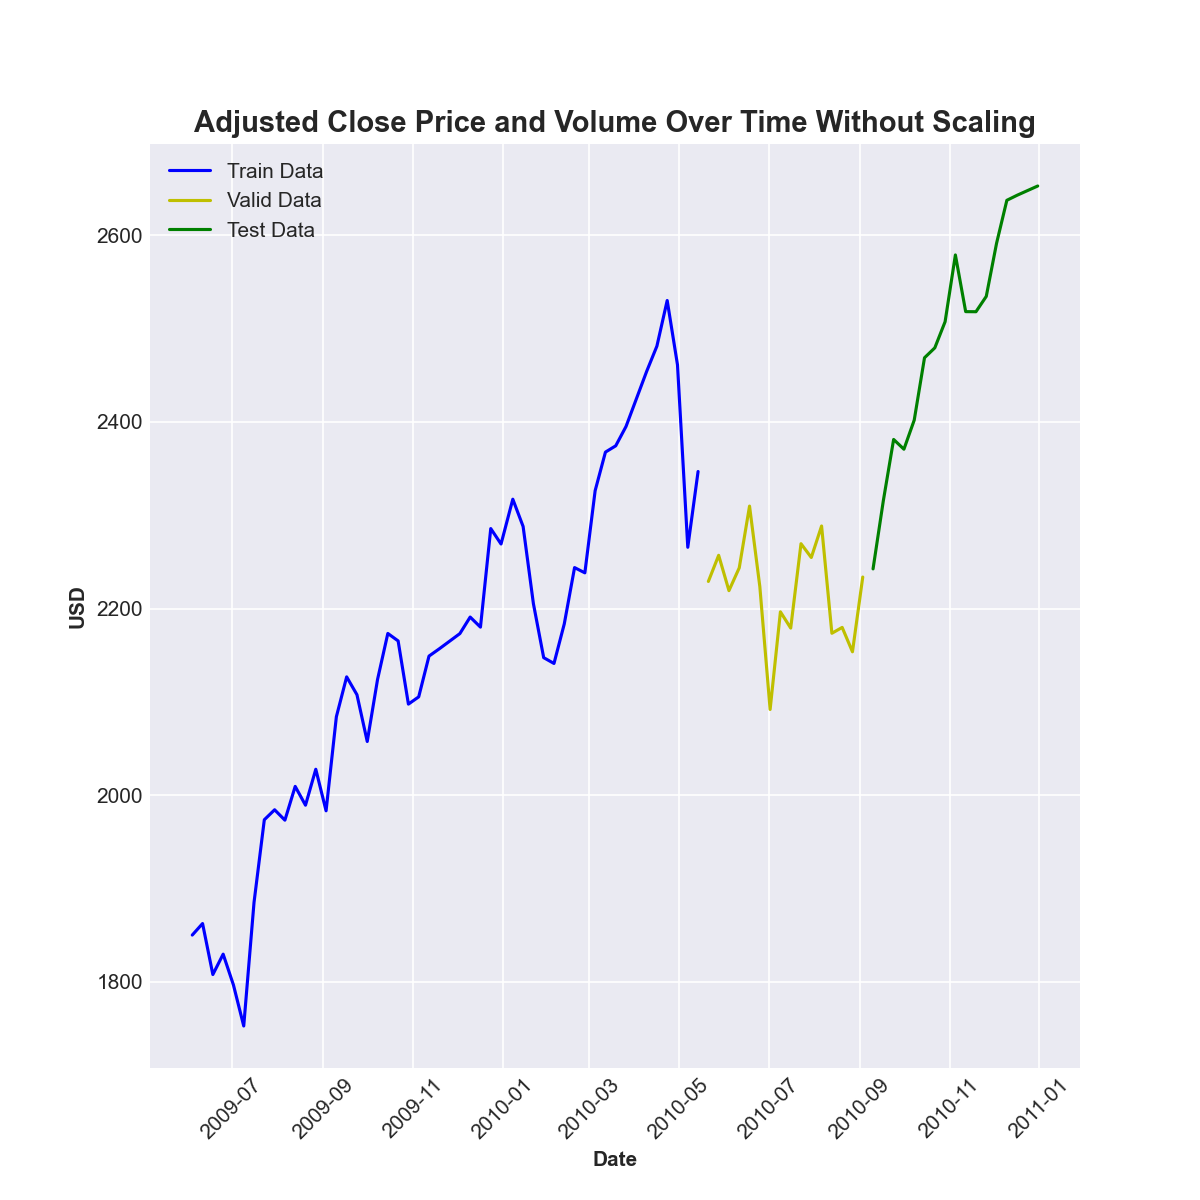

In [73]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.legend(['Train Data', 'Valid Data', 'Test Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xticks(rotation = 45)

plt.xlabel('Date', fontweight = 'bold')

mplcursors.cursor(hover = True)

plt.show()

<IPython.core.display.Javascript object>


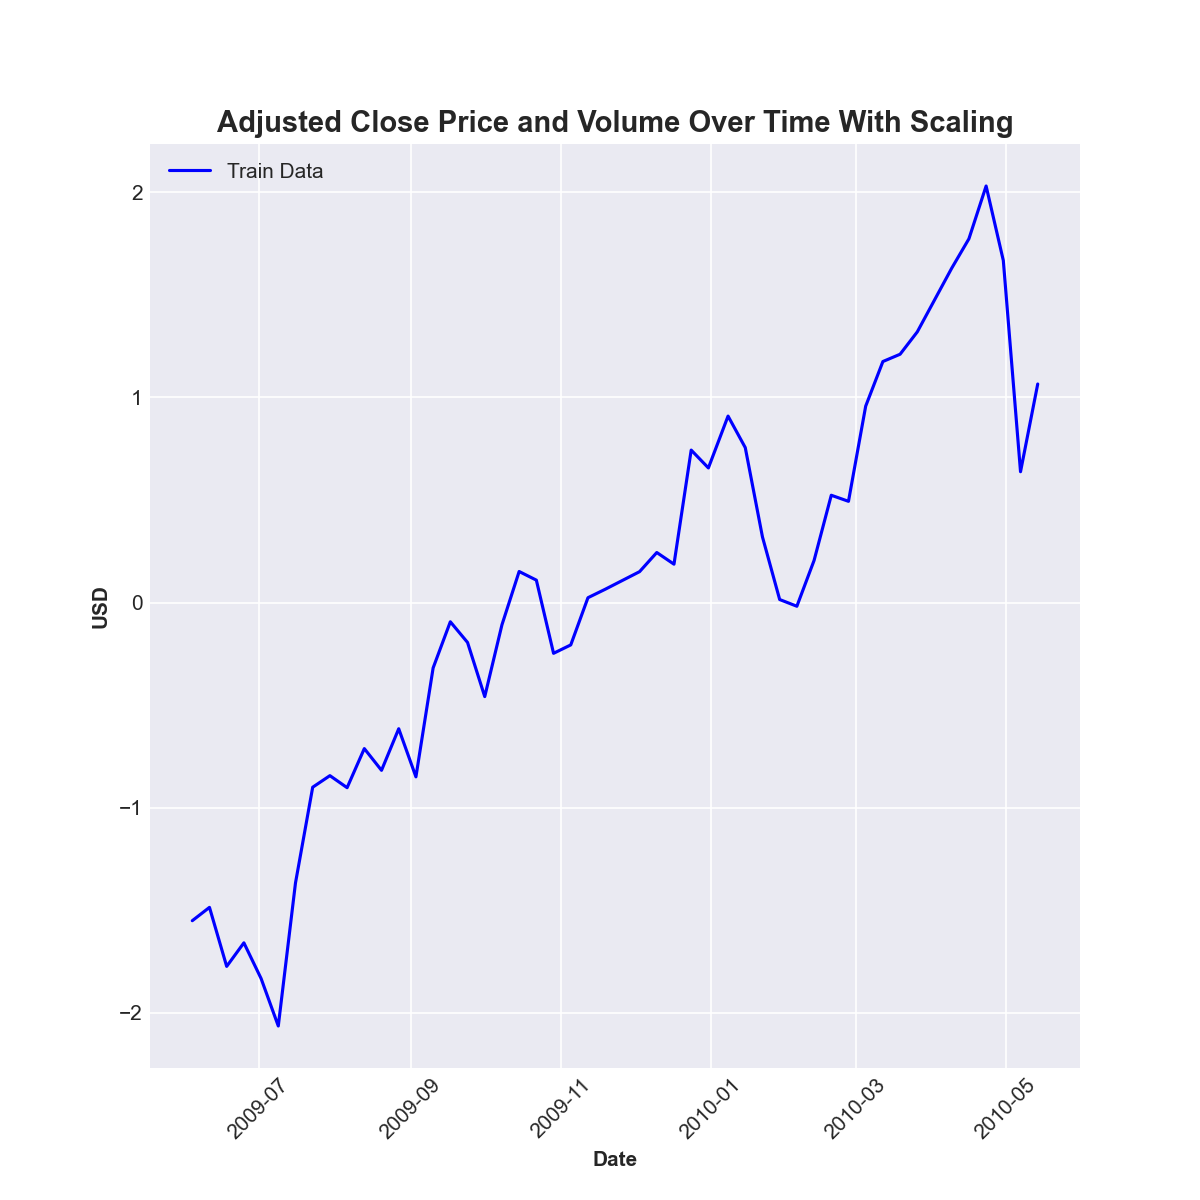

In [74]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train_df_scaled['DATE'], train_df_scaled['ADJ_CLOSE'], 'b-')
plt.legend(['Train Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time With Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [75]:
model = XGBRegressor(seed = model_seed,
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    learning_rate = learning_rate,
                    min_child_weight = min_child_weight,
                    subsample = subsample,
                    colsample_bytree = colsample_bytree,
                    colsample_bylevel = colsample_bylevel,
                    gamma = gamma)

model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=100, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [76]:
predict_train_scaled = model.predict(X_train_scaled)
predict_train = predict_train_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

predit_train_df = pd.DataFrame({'PREDICT_VALUE':predict_train,
                               'DATE':train['DATE']})

print('MSE on Train Set =', mean_squared_error(y_train, predict_train))
print('MAE on Train Set =', mean_absolute_error(y_train, predict_train))

MSE on Train Set = 0.547956713492619
MAE on Train Set = 0.5024490496419199


<IPython.core.display.Javascript object>


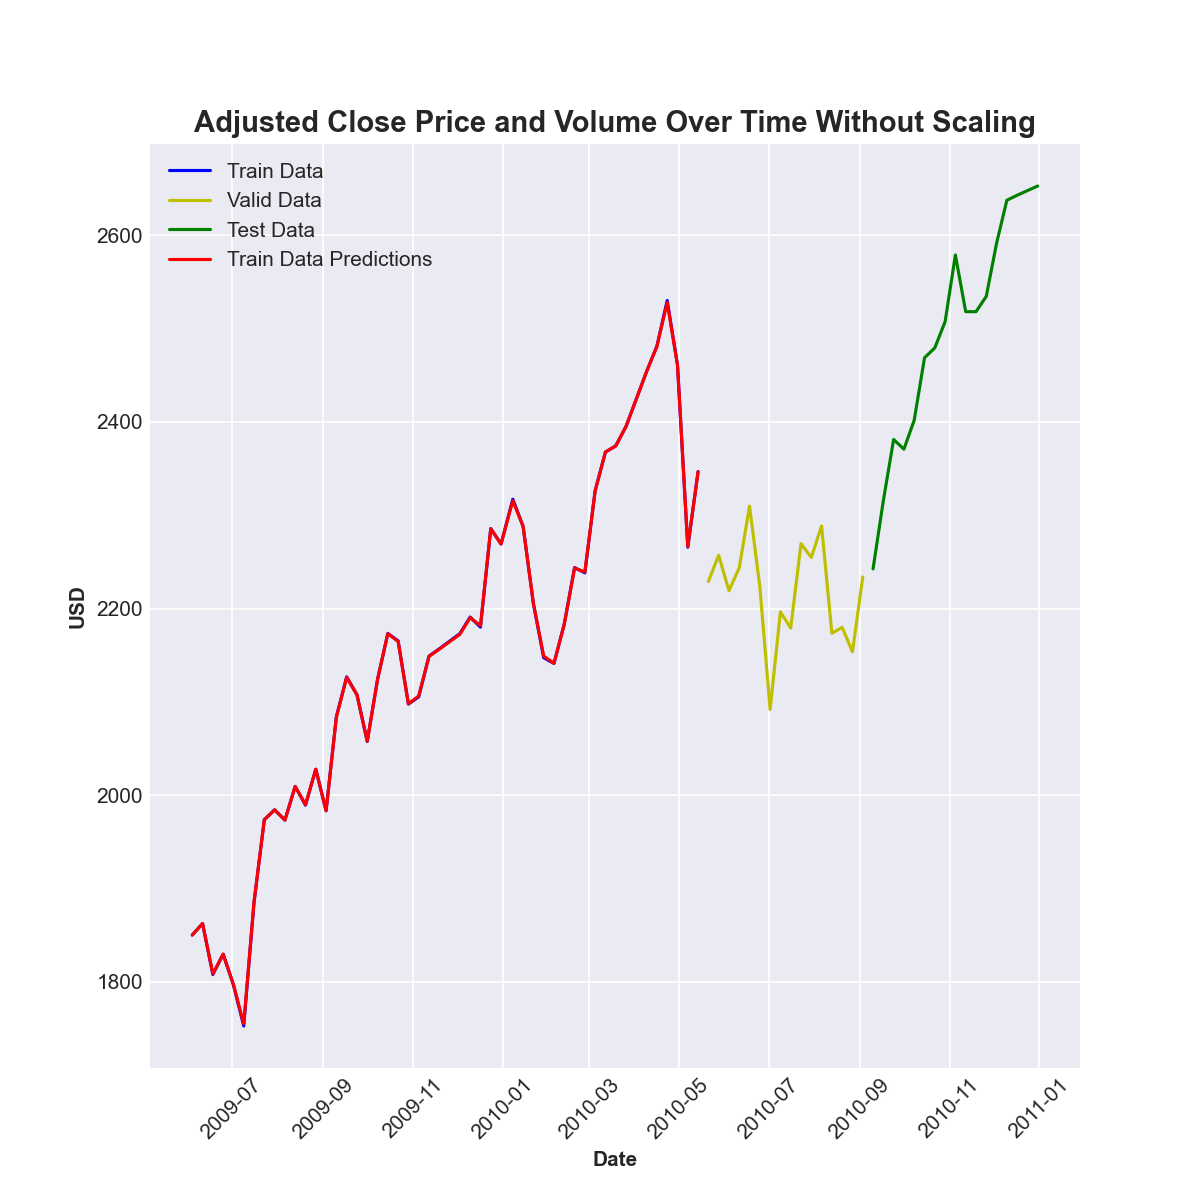

In [77]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_train_df['DATE'], predit_train_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [78]:
predict_valid_scaled = model.predict(X_valid_scaled)
valid['PREDICT_VALID'] = predict_valid_scaled
valid['PREDICT'] = valid['PREDICT_VALID'] * valid['ADJ_CLOSE_STD'] + valid['ADJ_CLOSE_MEAN']

predit_valid_df = pd.DataFrame({'PREDICT_VALUE':valid['PREDICT'],
                               'Y_VALID':y_valid,
                               'DATE':valid['DATE']})

MSE_Original = mean_squared_error(y_valid, valid['PREDICT'])
MAE_Original = mean_absolute_error(y_valid, valid['PREDICT'])

print('MSE on Validation Set =', mean_squared_error(y_valid, valid['PREDICT']))
print('MAE on Validation Set =', mean_absolute_error(y_valid, valid['PREDICT']))

MSE on Validation Set = 6741.580421145614
MAE on Validation Set = 70.23399558831977


<ipython-input-78-a804c29ca493>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['PREDICT_VALID'] = predict_valid_scaled
<ipython-input-78-a804c29ca493>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['PREDICT'] = valid['PREDICT_VALID'] * valid['ADJ_CLOSE_STD'] + valid['ADJ_CLOSE_MEAN']


<IPython.core.display.Javascript object>


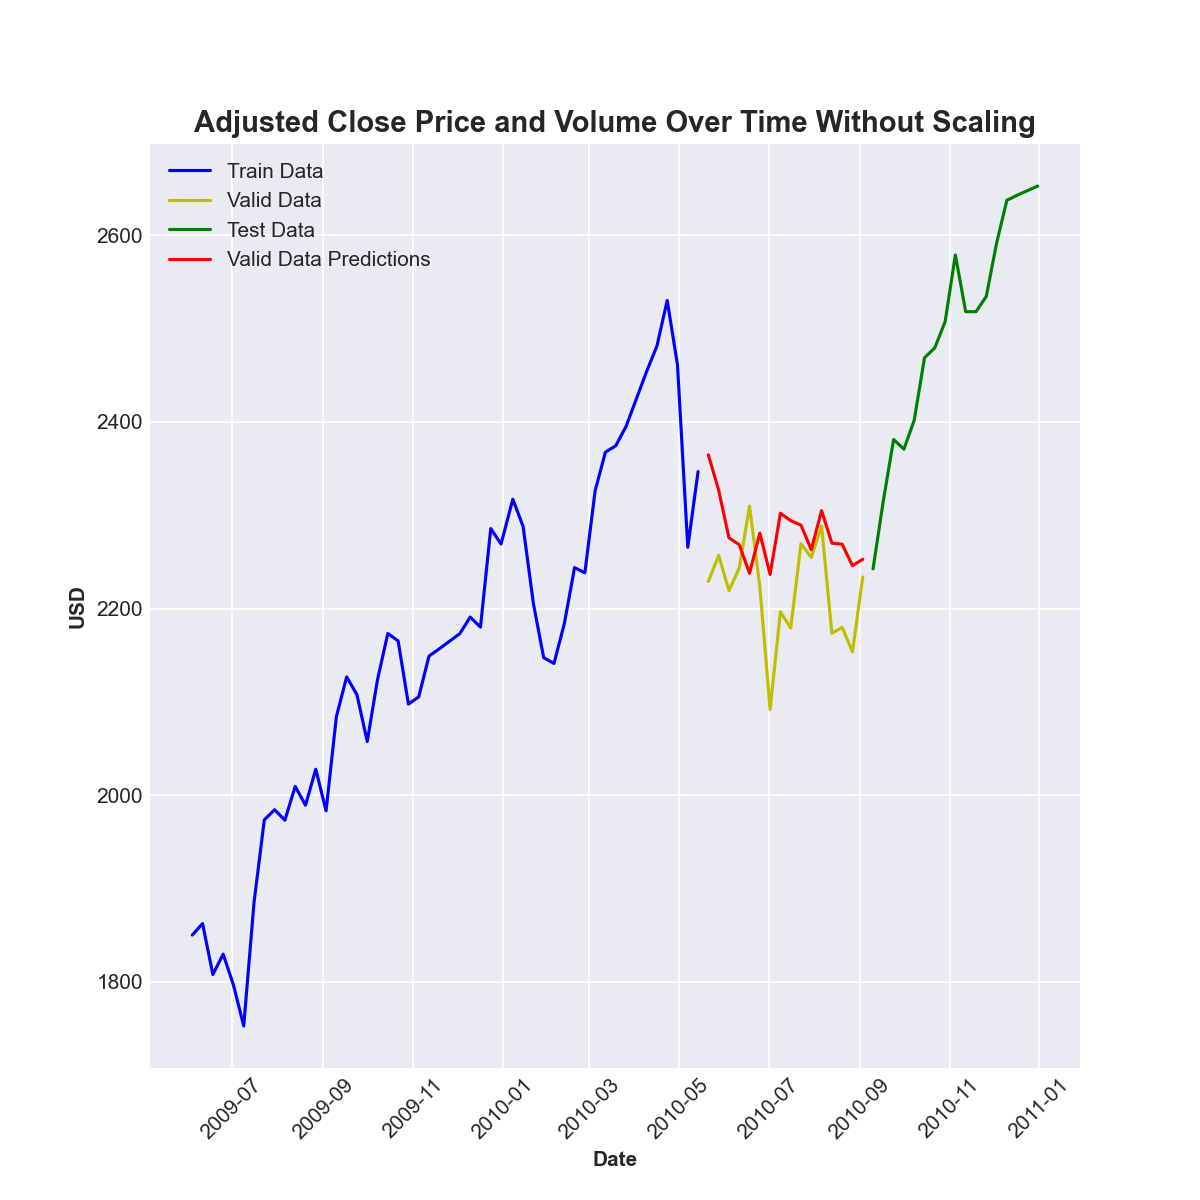

In [79]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_valid_df['DATE'], predit_valid_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Valid Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show();

### Preliminary Analysis

The analysis is clearly showing the predictions are well off. This can be due to the overfitting. The positive aspect is the model is able to predict the generic trend showing that it is on the right path, but does fall short of being accurate. In the world of finance we need efficiency and accuracy. To make this model better, I next went ahead and tuned the hyperparameters of the machine learning model.

### Tuning of XGBoost

First I needed to see what feature list is the most important or the most influential on machine learning model. I then took two parameters at a time of XGBoost and manually optimized the model and storing the optimum values to use for further tuning of the machine learning model.

- XGBoost Parameters:
    - n_estimators -> Specifies how many times to go through the modeling cycle
    - max_depth -> Maximum depth of a tree, large value can cause overfitting
    - learning_rate -> Shrinkage factor that avoids overfitting of the model
    - subsample -> Subsample ratio of the training instances, it will occur once in every boosting iteration
    - colsample_bytree -> Subsample ratio of columns when constructing each tree
    - colsample_bylevel -> Subsample ratio of columns for each level
    - gamma -> Minimum loss reduction required to make a futher partition of a leaf node of the tree

In [80]:
imp = list(zip(train[features_list], model.feature_importances_))
imp.sort(key = lambda tup: tup[1])
imp[-10:]

[('LOW_LAG_15', 0.013074145),
 ('ADJ_CLOSE_LAG_17', 0.014792283),
 ('HIGH_LAG_12', 0.014847541),
 ('OPEN_LAG_2', 0.023248399),
 ('LOW_LAG_1', 0.049728144),
 ('OPEN_LAG_14', 0.05018617),
 ('ADJ_CLOSE_LAG_4', 0.05229676),
 ('OPEN_LAG_18', 0.15921162),
 ('OPEN_LAG_19', 0.2427044),
 ('ADJ_CLOSE_LAG_8', 0.28163454)]

In [81]:
imp = list(zip(train[features_list], model.feature_importances_))
imp.sort(key = lambda tup: tup[1])

imp_10 = imp[-10:]

category = []
value = []

for imp in imp_10:
    category.append(imp[0])
    value.append(imp[1])

imp_df = pd.DataFrame({'FEATURE':category,
                      'IMPORTANCE':value})

imp_df

,FEATURE,IMPORTANCE
0,LOW_LAG_15,0.013074
1,ADJ_CLOSE_LAG_17,0.014792
2,HIGH_LAG_12,0.014848
3,OPEN_LAG_2,0.023248
4,LOW_LAG_1,0.049728
5,OPEN_LAG_14,0.050186
6,ADJ_CLOSE_LAG_4,0.052297
7,OPEN_LAG_18,0.159212
8,OPEN_LAG_19,0.242704
9,ADJ_CLOSE_LAG_8,0.281635


<IPython.core.display.Javascript object>


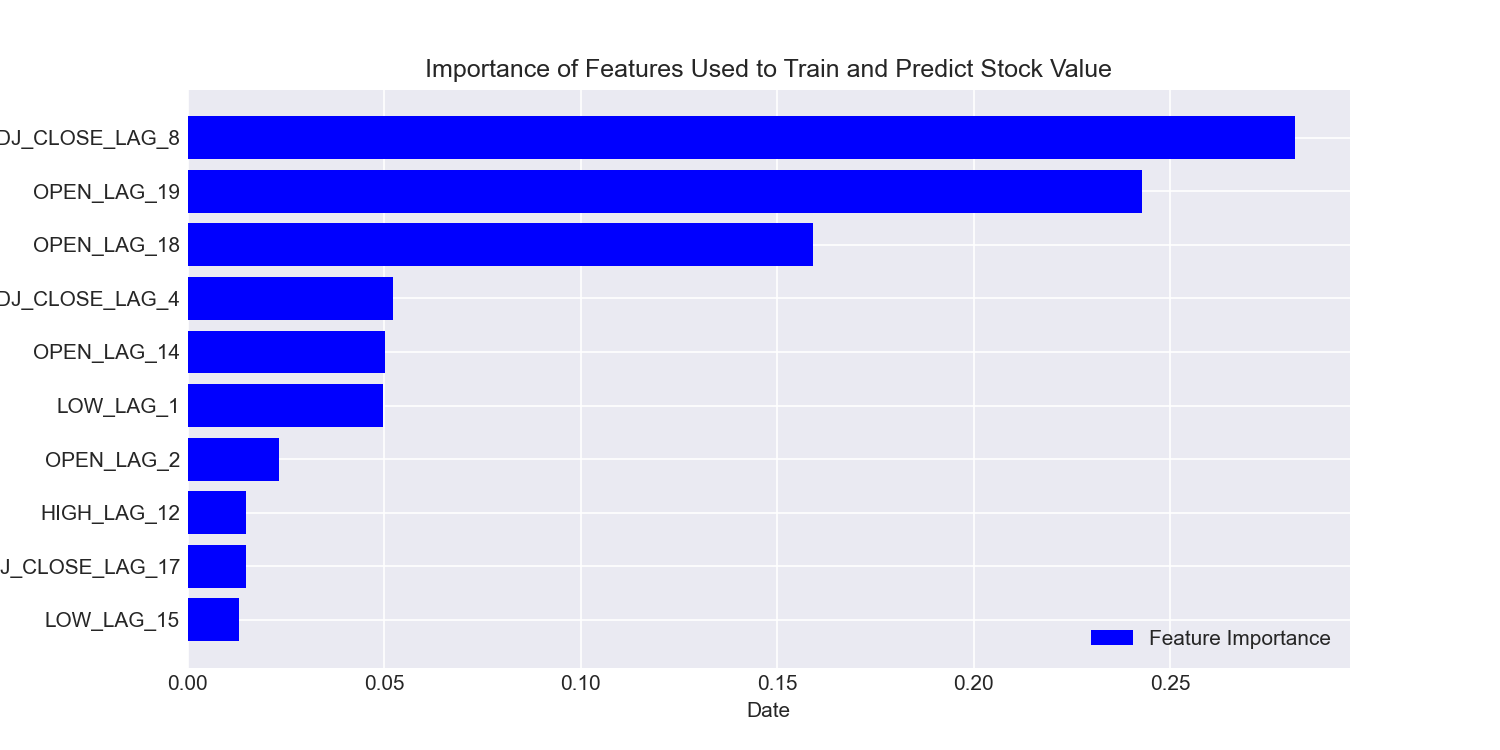

In [82]:
rcParams['figure.figsize'] = 10, 5

plt.figure()

plt.barh(imp_df['FEATURE'], imp_df['IMPORTANCE'], color = 'blue')
plt.legend(['Feature Importance'])
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title('Importance of Features Used to Train and Predict Stock Value')

mplcursors.cursor(hover = True)

plt.show()

In [83]:
n_estimators_parameter = 'n_estimators'
n_estimators_list = range(10, 500, 10)

max_depth_parameter = 'max_depth'
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rates = {n_estimators_parameter: [], max_depth_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(n_estimators_list):
    for param2 in max_depth_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = param,
                                                             max_depth = param2,
                                                             learning_rate = learning_rate,
                                                             min_child_weight = min_child_weight,
                                                             subsample = subsample,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = gamma)
        error_rates[n_estimators_parameter].append(param)
        error_rates[max_depth_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df1 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df1

<ipython-input-83-8cee86291e45>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(n_estimators_list):



Minutes Taken to Execute: 1.4147081573804219


,n_estimators,max_depth,MSE,MAE
0,10,2,7908.228413,71.987399
1,10,3,8800.911944,77.959576
2,10,4,8928.914025,80.263307
3,10,5,9111.915063,81.636159
4,10,6,9112.630656,81.641651
...,...,...,...,...
387,490,5,7670.827469,74.970909
388,490,6,7650.848809,75.122650
389,490,7,7653.883546,75.118428
390,490,8,7653.703831,75.116964


<IPython.core.display.Javascript object>


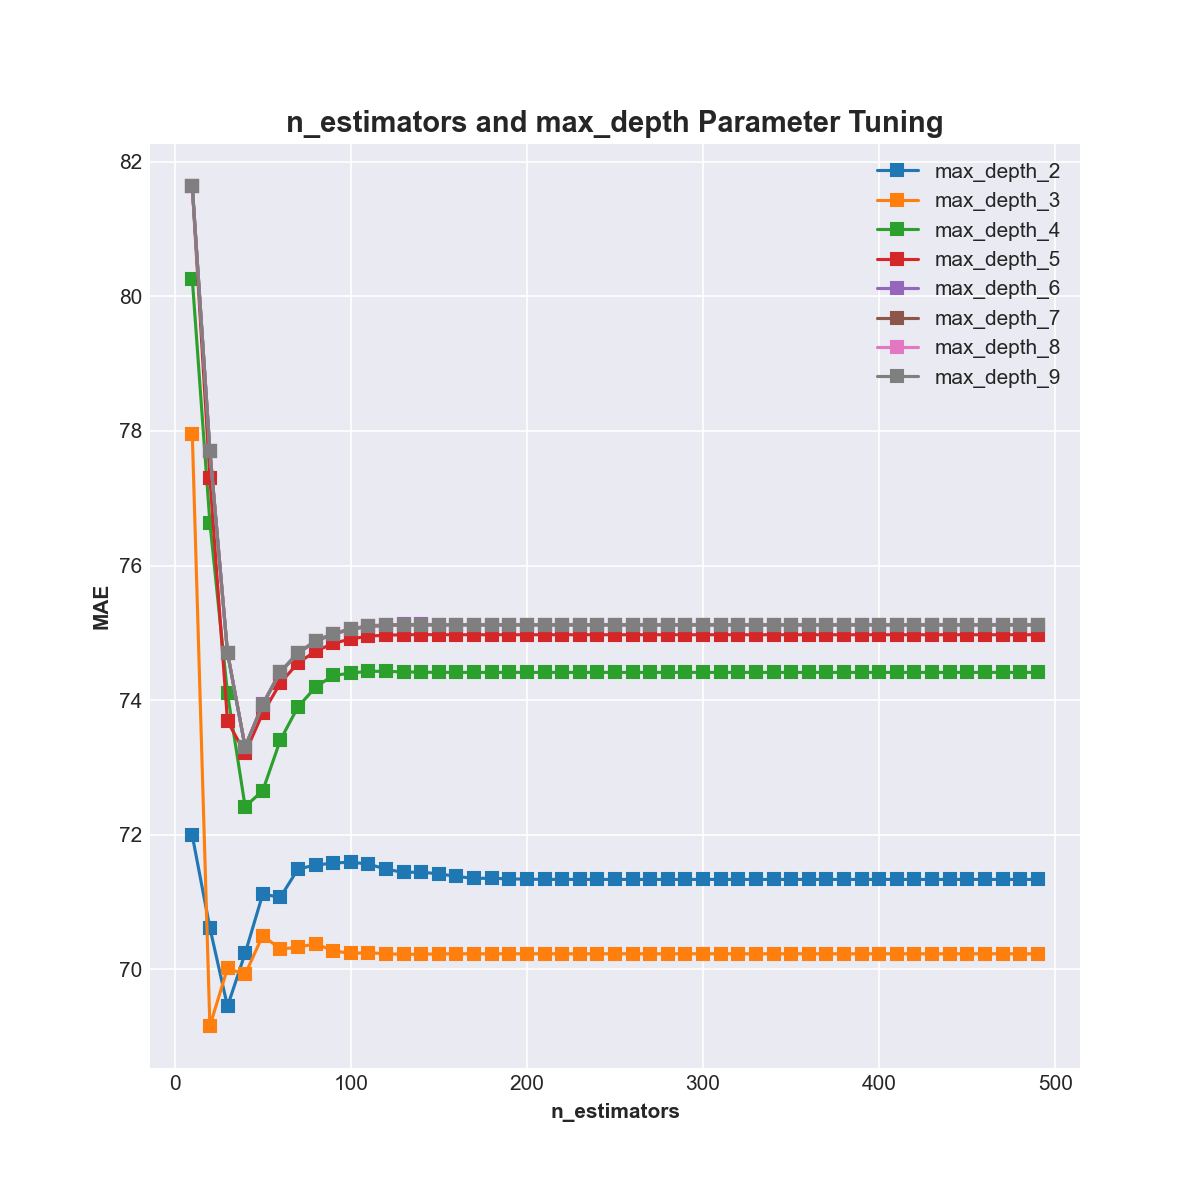

In [84]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(max_depth_list)):
    param = error_rate_df1[error_rate_df1[max_depth_parameter] == max_depth_list[p]]
    plt.plot(param[n_estimators_parameter], param['MAE'], marker = 's',)
    legend_list.append(max_depth_parameter + '_' + str(max_depth_list[p]))
    
plt.xlabel(n_estimators_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('n_estimators and max_depth Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right')

mplcursors.cursor(hover = True)

plt.show();

In [85]:
optimum = error_rate_df1[error_rate_df1['MSE'] == error_rate_df1['MSE'].min()]

print('Minimum MSE Value:', error_rate_df1['MSE'].min())
print('Optimum n_estimators Parameter:', optimum['n_estimators'].values[0])
print('Optimum max_depth Parameter:', optimum['max_depth'].values[0])

Minimum MSE Value: 6739.412494074872
Optimum n_estimators Parameter: 140
Optimum max_depth Parameter: 3


In [86]:
optimum = error_rate_df1[error_rate_df1['MAE'] == error_rate_df1['MAE'].min()]

n_estimators_optimum = optimum['n_estimators'].values[0]
max_depth_optimum = optimum['max_depth'].values[0]

print('Minimum MAE Value:', error_rate_df1['MAE'].min())
print('Optimum n_estimators Parameter:', optimum['n_estimators'].values[0])
print('Optimum max_depth Parameter:', optimum['max_depth'].values[0])

Minimum MAE Value: 69.15472546929476
Optimum n_estimators Parameter: 20
Optimum max_depth Parameter: 3


In [87]:
learning_rate_parameter = 'learning_rate'
learning_rate_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

min_child_weight_parameter = 'min_child_weight'
min_child_weight_list = range(5, 21, 1)

error_rates = {learning_rate_parameter: [], min_child_weight_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(learning_rate_list):
    for param2 in min_child_weight_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = param,
                                                             min_child_weight = param2,
                                                             subsample = subsample,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = gamma)
        error_rates[learning_rate_parameter].append(param)
        error_rates[min_child_weight_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df2 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df2

<ipython-input-87-5e425274f179>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(learning_rate_list):



Minutes Taken to Execute: 0.07580806414286295


,learning_rate,min_child_weight,MSE,MAE
0,0.001,5,11376.008785,85.816974
1,0.001,6,11388.745944,85.882263
2,0.001,7,11388.745944,85.882263
3,0.001,8,11363.522440,85.830829
4,0.001,9,11354.051351,85.793261
...,...,...,...,...
107,0.300,16,5115.242322,62.599379
108,0.300,17,5553.190678,63.792631
109,0.300,18,5711.946431,64.464305
110,0.300,19,5962.550586,66.959584


<IPython.core.display.Javascript object>


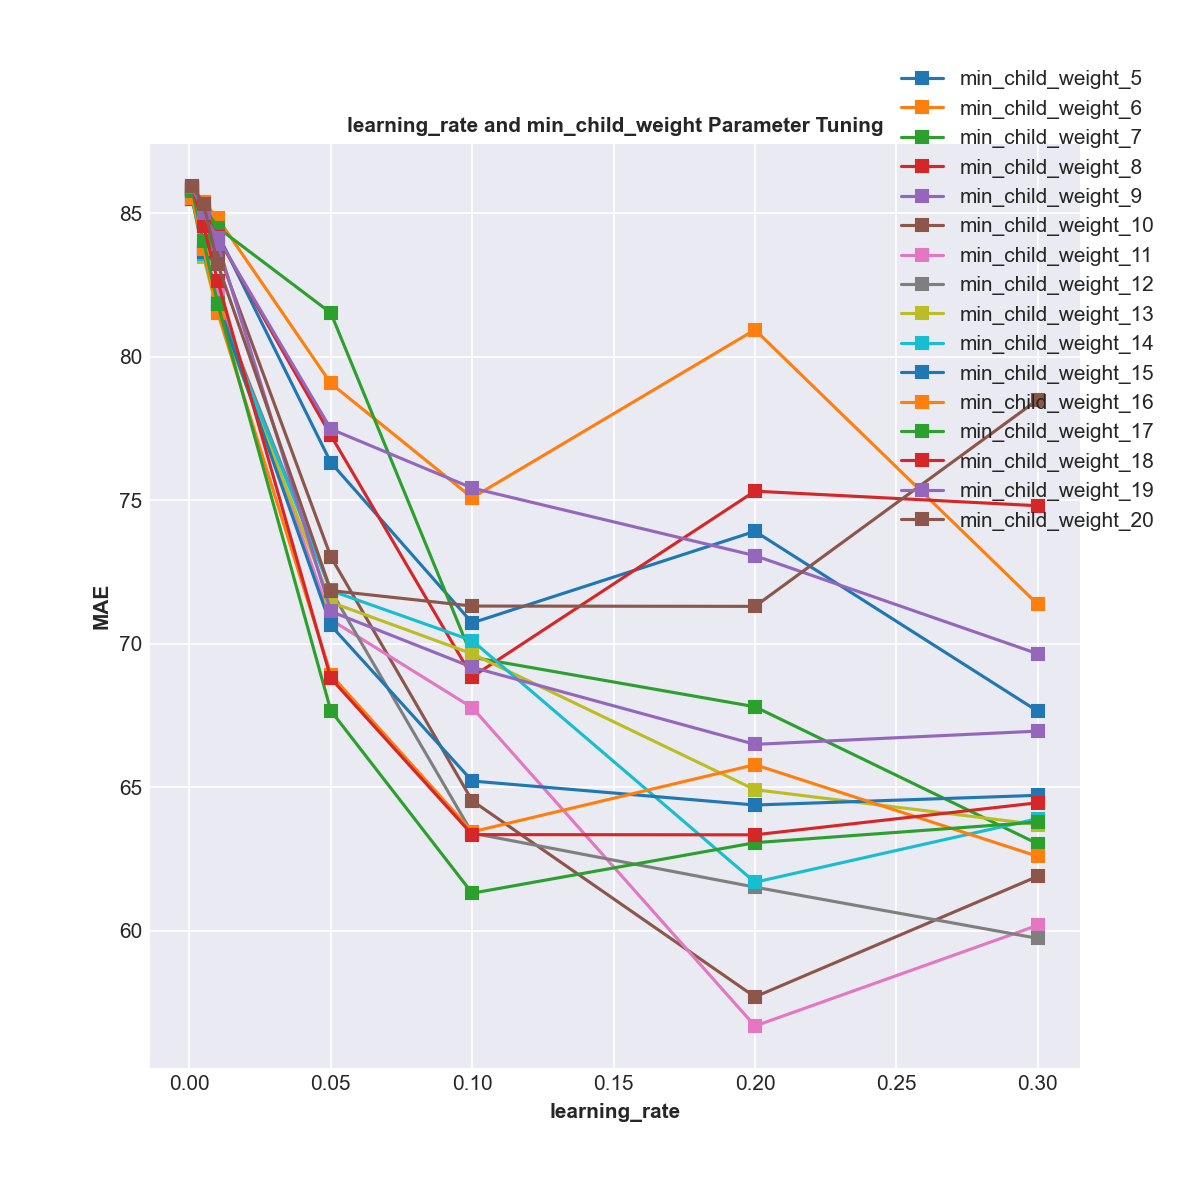

In [88]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(min_child_weight_list)):
    param = error_rate_df2[error_rate_df2[min_child_weight_parameter] == min_child_weight_list[p]]
    plt.plot(param[learning_rate_parameter], param['MAE'], marker = 's',)
    legend_list.append(min_child_weight_parameter + '_' + str(min_child_weight_list[p]))
    
plt.xlabel(learning_rate_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('learning_rate and min_child_weight Parameter Tuning', fontsize = 10, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right', bbox_to_anchor = (1.1, 1.1))

mplcursors.cursor(hover = True)

plt.show();

In [89]:
optimum = error_rate_df2[error_rate_df2['MSE'] == error_rate_df2['MSE'].min()]

print('Minimum MSE Value:', error_rate_df2['MSE'].min())
print('Optimum learning_rate Parameter:', optimum['learning_rate'].values[0])
print('Optimum min_child_weight Parameter:', optimum['min_child_weight'].values[0])

Minimum MSE Value: 4805.761288099071
Optimum learning_rate Parameter: 0.3
Optimum min_child_weight Parameter: 12


In [90]:
optimum = error_rate_df2[error_rate_df2['MAE'] == error_rate_df2['MAE'].min()]

learning_rate_optimum = optimum['learning_rate'].values[0]
min_child_weight_optimum = optimum['min_child_weight'].values[0]

print('Minimum MAE Value:', error_rate_df2['MAE'].min())
print('Optimum learning_rate Parameter:', optimum['learning_rate'].values[0])
print('Optimum min_child_weight Parameter:', optimum['min_child_weight'].values[0])

Minimum MAE Value: 56.690414514654236
Optimum learning_rate Parameter: 0.2
Optimum min_child_weight Parameter: 11


In [91]:
subsample_parameter = 'subsample'
subsample_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

gamma_parameter = 'gamma'
gamma_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

error_rates = {subsample_parameter: [], gamma_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(subsample_list):
    for param2 in gamma_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = param,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = param2)
        error_rates[subsample_parameter].append(param)
        error_rates[gamma_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df3 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df3

<ipython-input-91-000a039edf79>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(subsample_list):



Minutes Taken to Execute: 0.061928435166676836


,subsample,gamma,MSE,MAE
0,0.1,0.1,7556.951882,72.696442
1,0.1,0.2,7556.951882,72.696442
2,0.1,0.3,7556.951882,72.696442
3,0.1,0.4,7556.951882,72.696442
4,0.1,0.5,7556.951882,72.696442
...,...,...,...,...
95,1.0,0.6,5183.248612,59.287965
96,1.0,0.7,5052.056109,58.812311
97,1.0,0.8,5009.477096,58.991906
98,1.0,0.9,5009.477096,58.991906


<IPython.core.display.Javascript object>


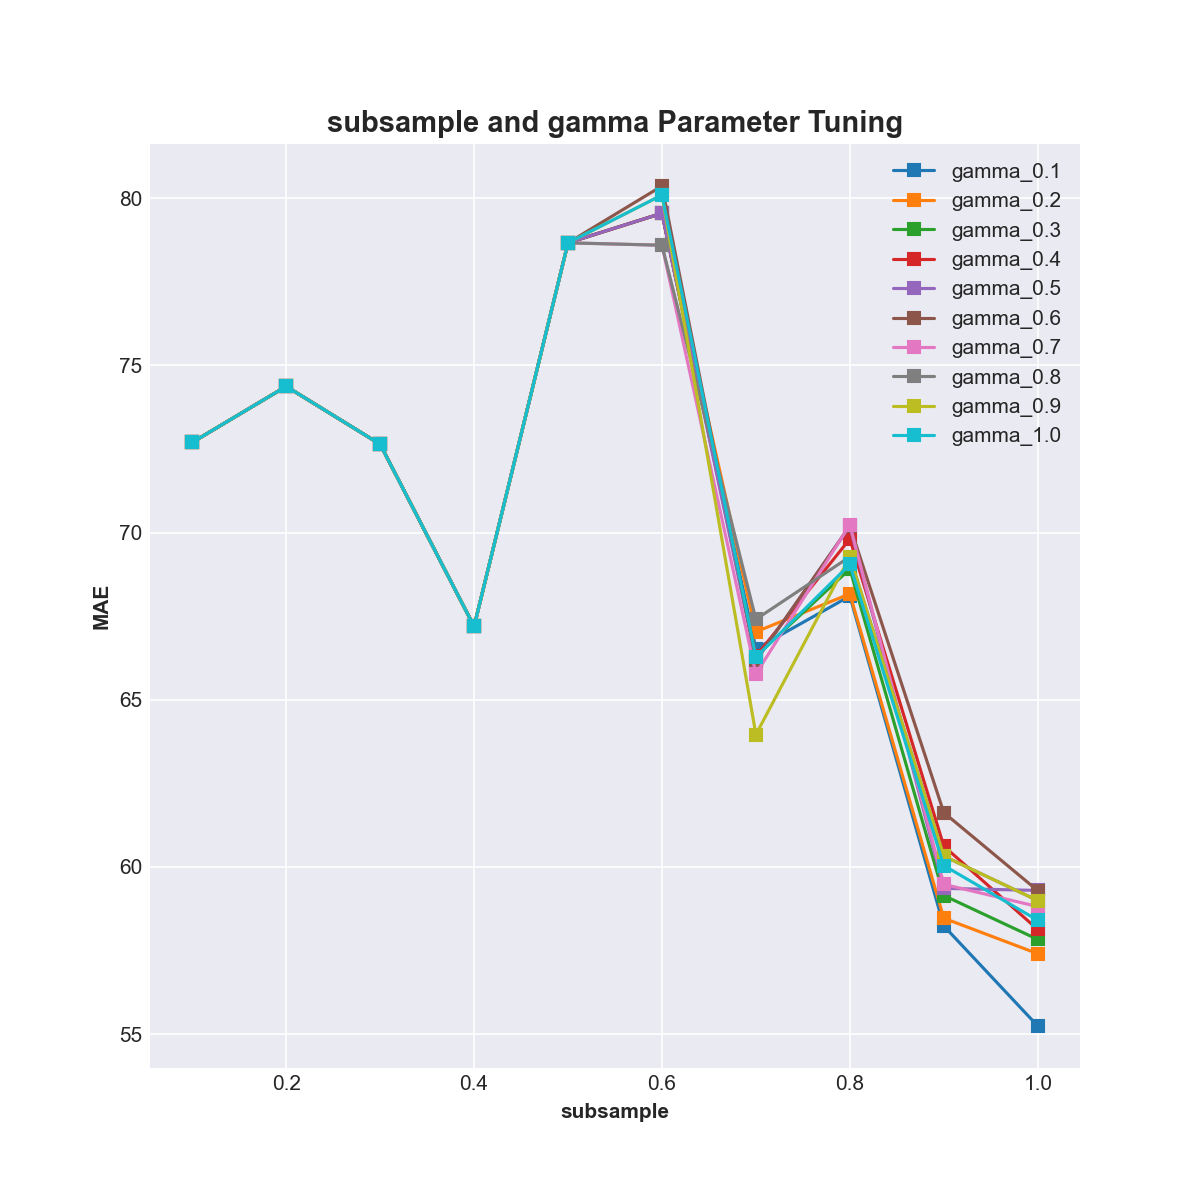

In [92]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(gamma_list)):
    param = error_rate_df3[error_rate_df3[gamma_parameter] == gamma_list[p]]
    plt.plot(param[subsample_parameter], param['MAE'], marker = 's',)
    legend_list.append(gamma_parameter + '_' + str(gamma_list[p]))
    
plt.xlabel(subsample_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('subsample and gamma Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right')

mplcursors.cursor(hover = True)

plt.show();

In [93]:
optimum = error_rate_df3[error_rate_df3['MSE'] == error_rate_df3['MSE'].min()]

print('Minimum MSE Value:', error_rate_df3['MSE'].min())
print('Optimum subsample Parameter:', optimum['subsample'].values[0])
print('Optimum gamma Parameter:', optimum['gamma'].values[0])

Minimum MSE Value: 4588.415908037325
Optimum subsample Parameter: 1.0
Optimum gamma Parameter: 0.1


In [94]:
optimum = error_rate_df3[error_rate_df3['MAE'] == error_rate_df3['MAE'].min()]

subsample_optimum = optimum['subsample'].values[0]
gamma_optimum = optimum['gamma'].values[0]

print('Minimum MAE Value:', error_rate_df3['MAE'].min())
print('Optimum subsample Parameter:', optimum['subsample'].values[0])
print('Optimum gamma Parameter:', optimum['gamma'].values[0])

Minimum MAE Value: 55.24020916832296
Optimum subsample Parameter: 1.0
Optimum gamma Parameter: 0.1


In [95]:
colsample_bytree_parameter = 'colsample_bytree'
colsample_bytree_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

colsample_bylevel_parameter = 'colsample_bylevel'
colsample_bylevel_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

error_rates = {colsample_bytree_parameter: [], colsample_bylevel_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(colsample_bytree_list):
    for param2 in colsample_bylevel_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = subsample_optimum,
                                                             colsample_bytree = param,
                                                             colsample_bylevel = param2,
                                                             gamma = gamma_optimum)
        error_rates[colsample_bytree_parameter].append(param)
        error_rates[colsample_bylevel_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df4 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df4

<ipython-input-95-e3d8ff646ff8>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(colsample_bytree_list):



Minutes Taken to Execute: 0.02337947686513265


,colsample_bytree,colsample_bylevel,MSE,MAE
0,0.5,0.5,5185.075446,58.366744
1,0.5,0.6,5175.119032,58.757127
2,0.5,0.7,5255.034609,58.487731
3,0.5,0.8,6105.331196,63.074815
4,0.5,0.9,6445.816100,65.541156
5,0.5,1.0,6411.877463,65.596191
6,0.6,0.5,6184.467658,63.981277
7,0.6,0.6,6531.087085,66.658141
8,0.6,0.7,6516.386747,66.702307
9,0.6,0.8,5967.895280,62.280290


<IPython.core.display.Javascript object>


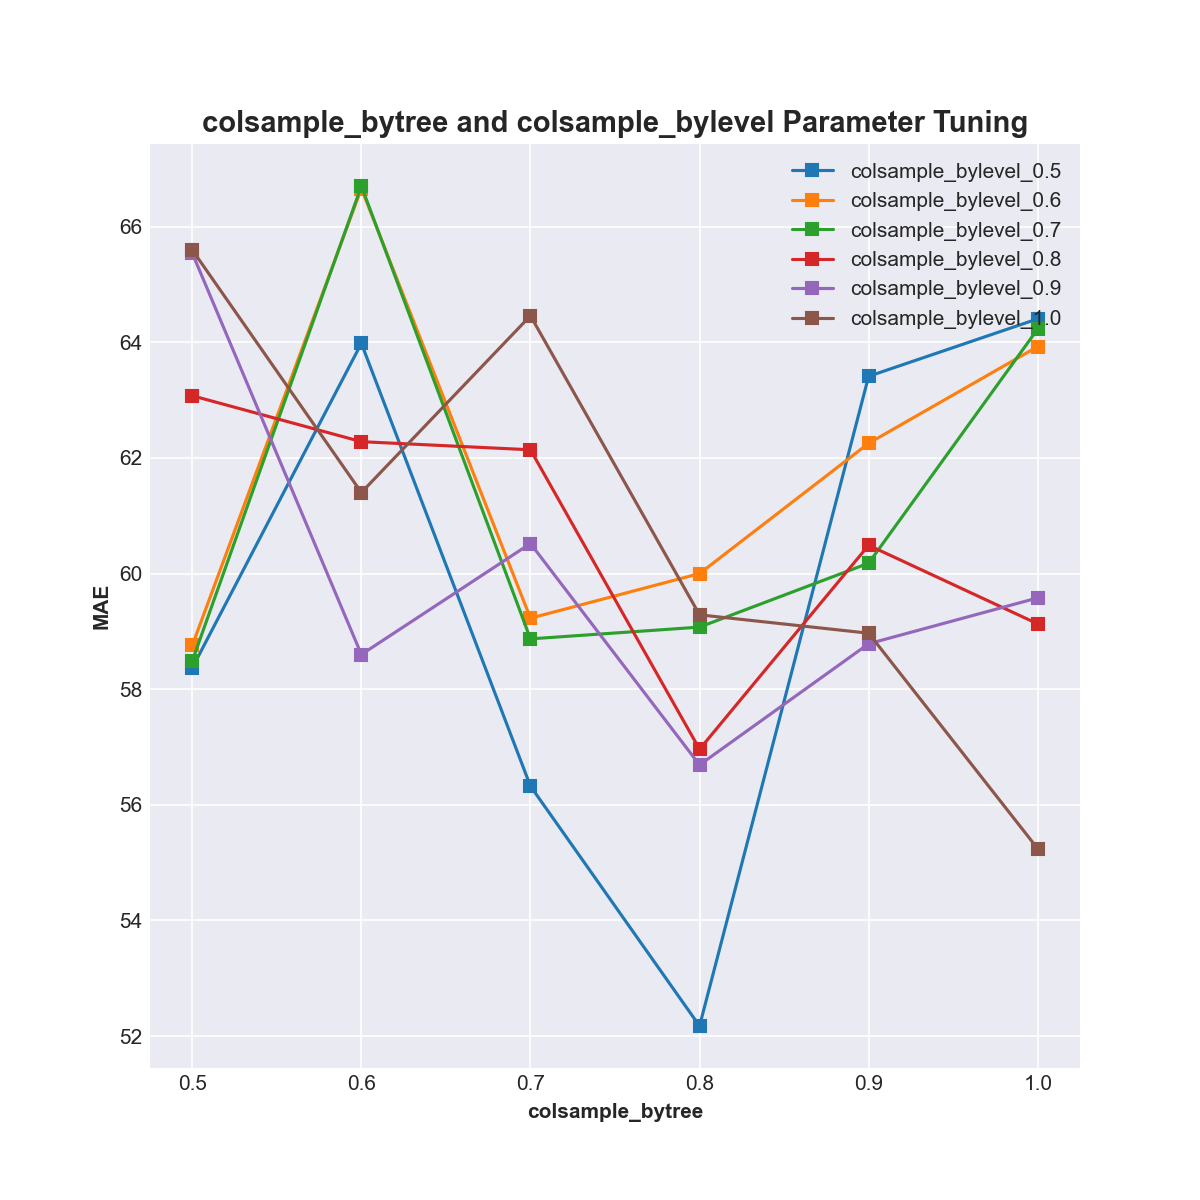

In [96]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(colsample_bylevel_list)):
    param = error_rate_df4[error_rate_df4[colsample_bylevel_parameter] == colsample_bylevel_list[p]]
    plt.plot(param[colsample_bytree_parameter], param['MAE'], marker = 's',)
    legend_list.append(colsample_bylevel_parameter + '_' + str(colsample_bylevel_list[p]))
    
plt.xlabel(colsample_bytree_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('colsample_bytree and colsample_bylevel Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right')

mplcursors.cursor(hover = True)

plt.show();

In [97]:
optimum = error_rate_df4[error_rate_df4['MSE'] == error_rate_df4['MSE'].min()]

MSE_Optimum = error_rate_df4['MSE'].min()

print('Minimum MSE Value:', error_rate_df4['MSE'].min())
print('Optimum colsample_bytree Parameter:', optimum['colsample_bytree'].values[0])
print('Optimum colsample_bylevel Parameter:', optimum['colsample_bylevel'].values[0])

Minimum MSE Value: 4006.8022711488156
Optimum colsample_bytree Parameter: 0.8
Optimum colsample_bylevel Parameter: 0.5


In [98]:
optimum = error_rate_df4[error_rate_df4['MAE'] == error_rate_df4['MAE'].min()]

MAE_Optimum = error_rate_df4['MAE'].min()

colsample_bytree_optimum = optimum['colsample_bytree'].values[0]
colsample_bylevel_optimum = optimum['colsample_bylevel'].values[0]

print('Minimum MAE Value:', error_rate_df4['MAE'].min())
print('Optimum colsample_bytree Parameter:', optimum['colsample_bytree'].values[0])
print('Optimum colsample_bylevel Parameter:', optimum['colsample_bylevel'].values[0])

Minimum MAE Value: 52.174011914885796
Optimum colsample_bytree Parameter: 0.8
Optimum colsample_bylevel Parameter: 0.5


### Overview of Optimized Values

I have graphed the opimized values to visually represent this analysis and clearly understand what the new values are and how the error values are impacted to show the effect of tuning parameters.

In [99]:
tuned_params_df = pd.DataFrame({'PARAMETER':['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma'],
                               'ORIGINAL':[n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma],
                               'OPTIMUM':[n_estimators_optimum, max_depth_optimum, learning_rate_optimum, min_child_weight_optimum, subsample_optimum, colsample_bytree_optimum, colsample_bylevel_optimum, gamma_optimum]})

MSE_values_df = pd.DataFrame({'PARAMETER':['MSE'],
                                    'ORIGINAL':[MSE_Original],
                                    'OPTIMUM':[MSE_Optimum]})

MAE_values_df = pd.DataFrame({'PARAMETER':['MAE'],
                                    'ORIGINAL':[MAE_Original],
                                    'OPTIMUM':[MAE_Optimum]})

tuned_params_df

,PARAMETER,ORIGINAL,OPTIMUM
0,n_estimators,100.0,20.0
1,max_depth,3.0,3.0
2,learning_rate,0.1,0.2
3,min_child_weight,1.0,11.0
4,subsample,1.0,1.0
5,colsample_bytree,1.0,0.8
6,colsample_bylevel,1.0,0.5
7,gamma,0.0,0.1


In [100]:
MSE_values_df

,PARAMETER,ORIGINAL,OPTIMUM
0,MSE,6741.580421,4006.802271


In [101]:
MAE_values_df

,PARAMETER,ORIGINAL,OPTIMUM
0,MAE,70.233996,52.174012


<IPython.core.display.Javascript object>


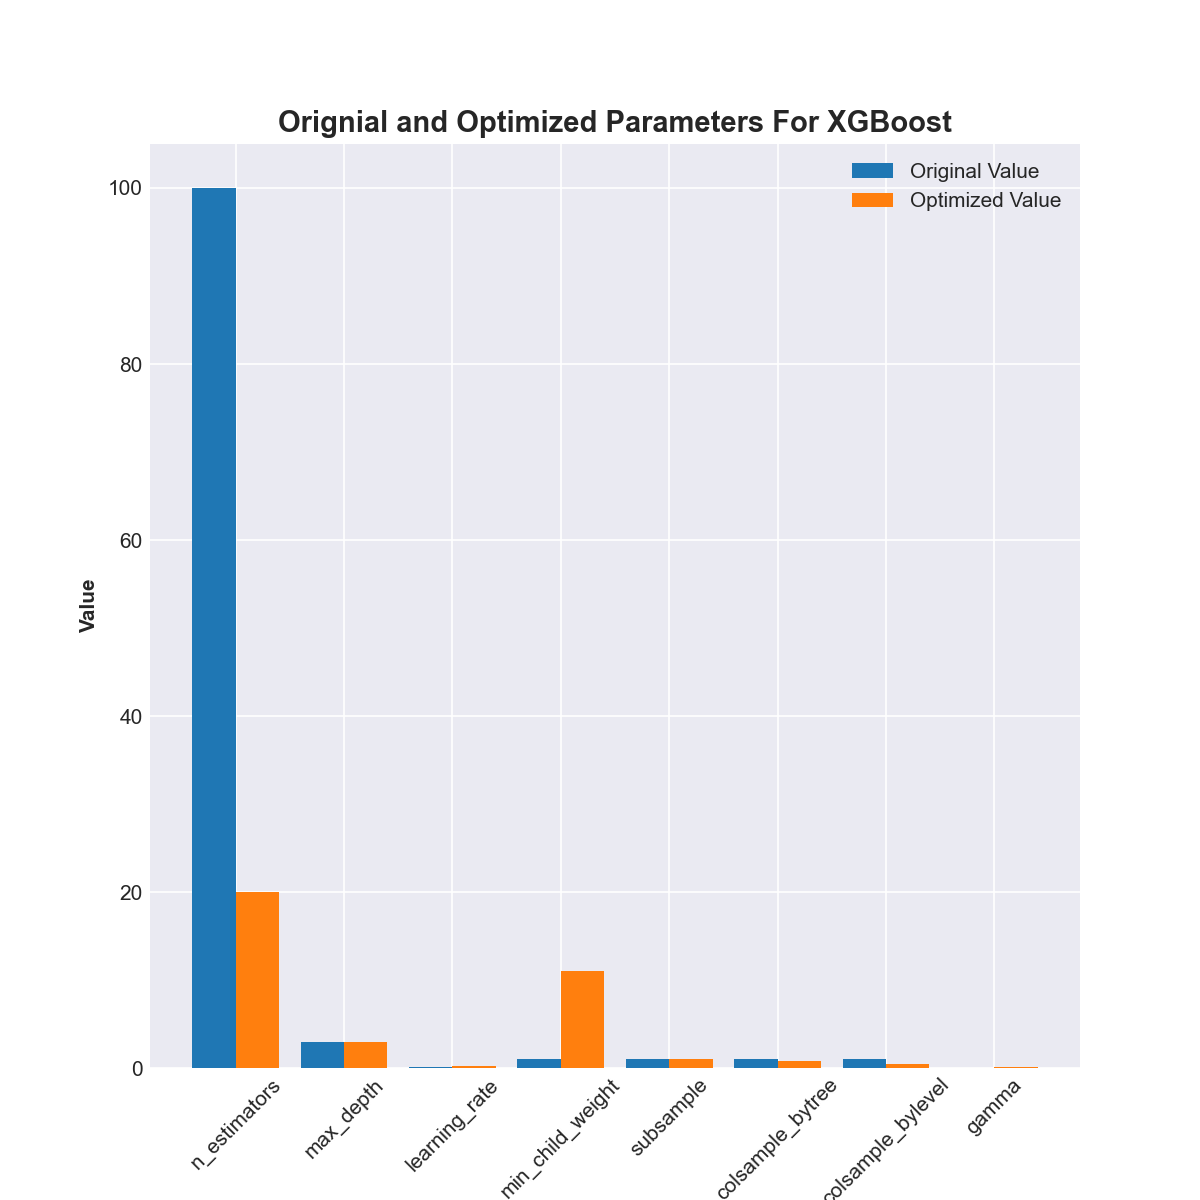

In [102]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_parameters = [tuned_params_df['ORIGINAL'], tuned_params_df['OPTIMUM']]
X_parameters = tuned_params_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_parameters)
_X = np.arange(len(X_parameters))
for i in range(len(vals_parameters)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_parameters[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_parameters, rotation=45)
plt.title('Orignial and Optimized Parameters For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Parameters', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

<IPython.core.display.Javascript object>


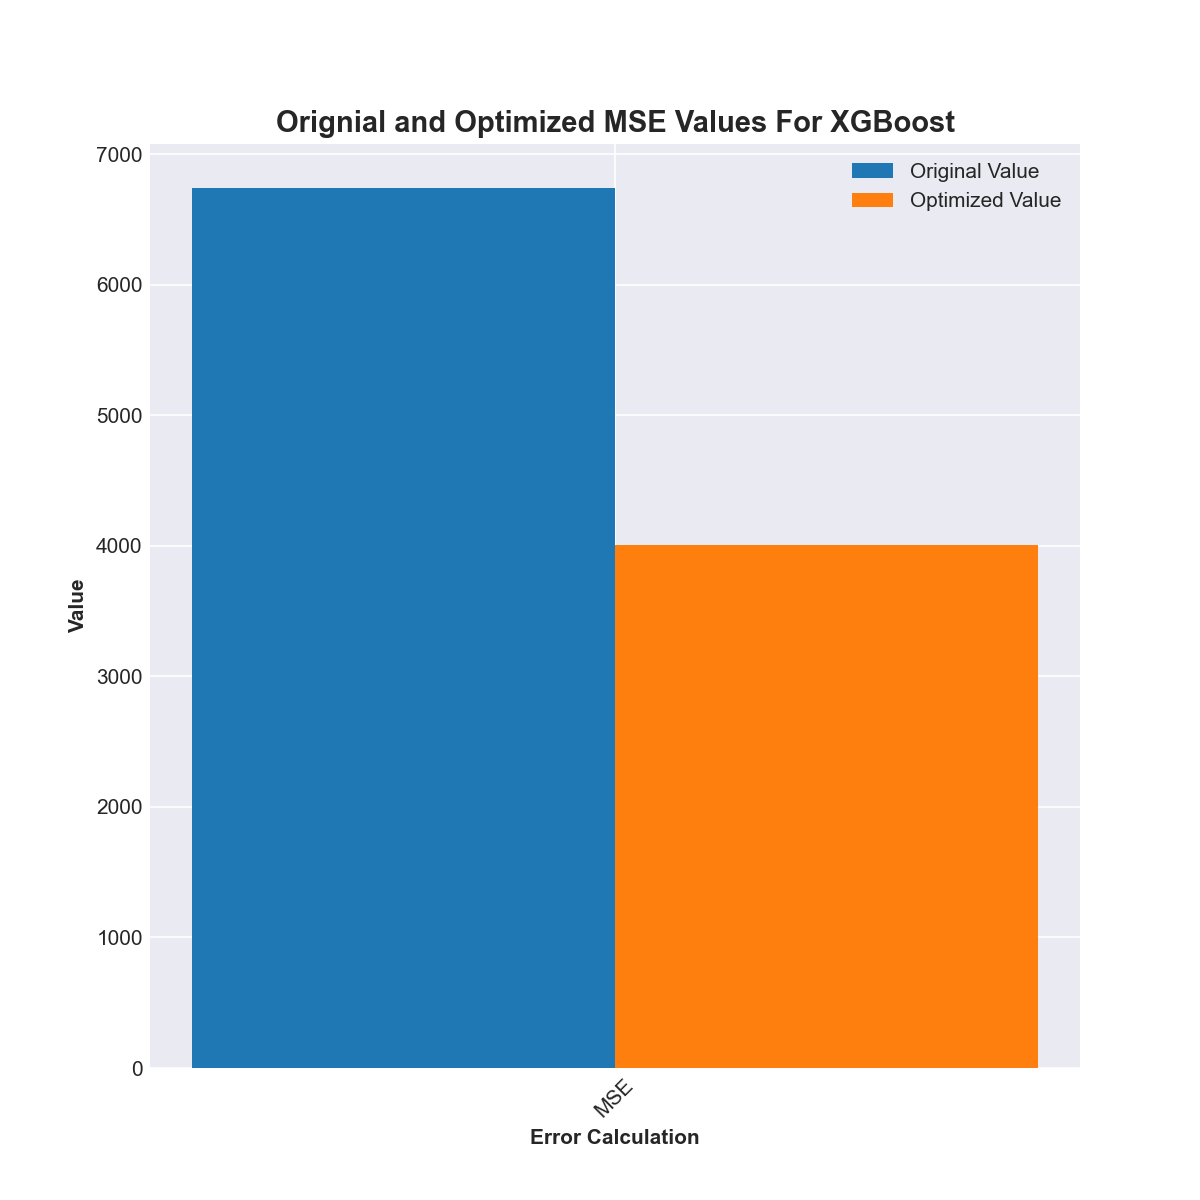

In [103]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_MSE = [MSE_values_df['ORIGINAL'], MSE_values_df['OPTIMUM']]
X_MSE = MSE_values_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_MSE)
_X = np.arange(len(X_MSE))
for i in range(len(vals_MSE)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_MSE[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_MSE, rotation=45)
plt.title('Orignial and Optimized MSE Values For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Error Calculation', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

<IPython.core.display.Javascript object>


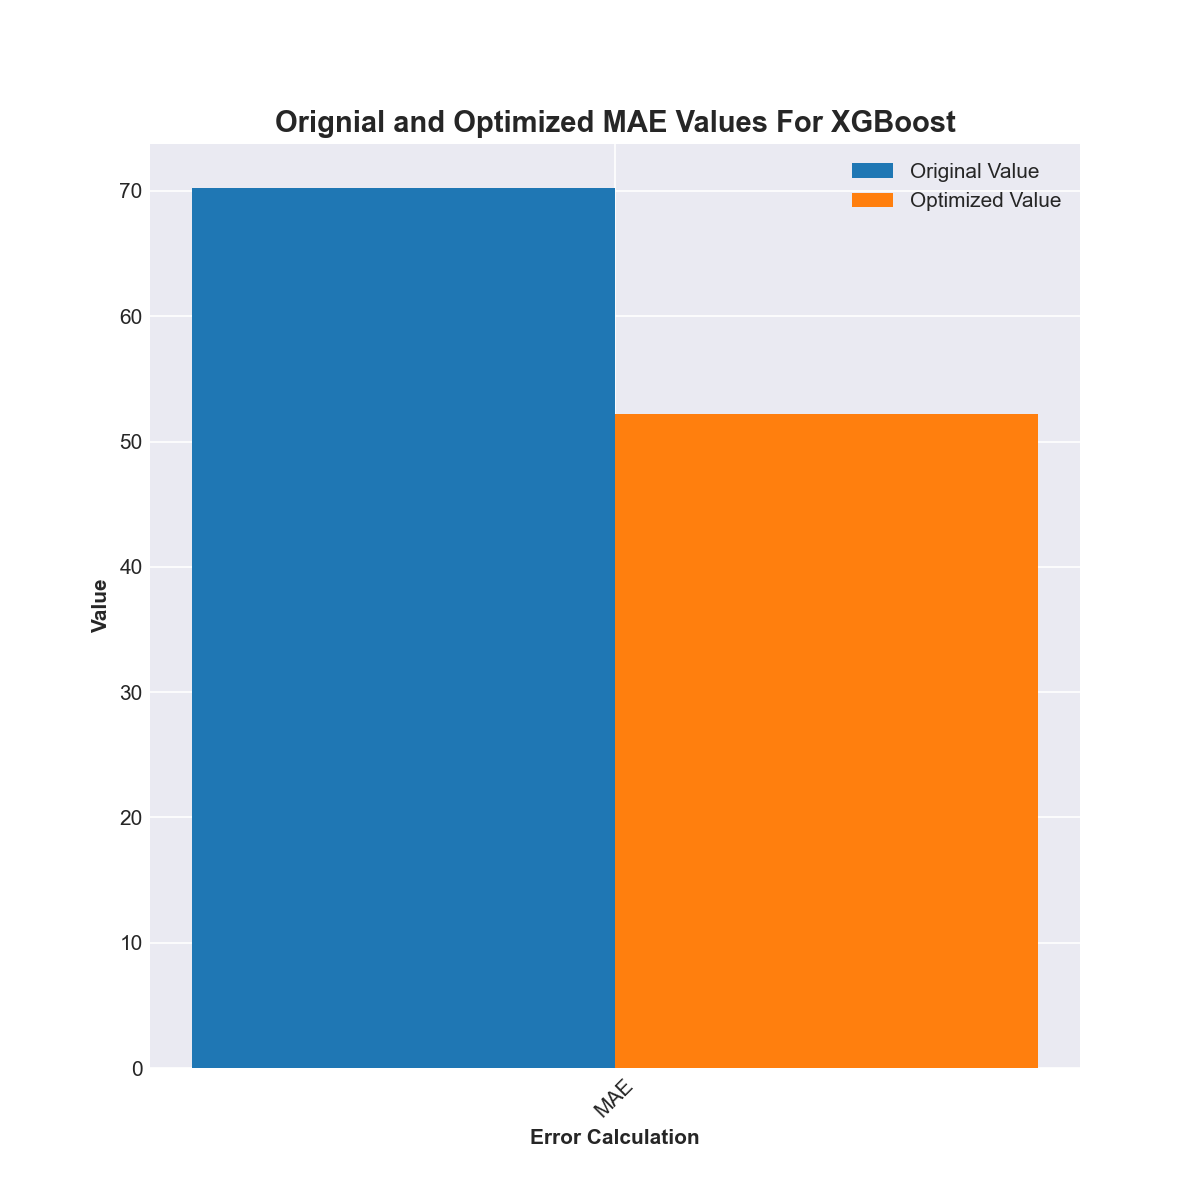

In [104]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_MAE = [MAE_values_df['ORIGINAL'], MAE_values_df['OPTIMUM']]
X_MAE = MAE_values_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_MAE)
_X = np.arange(len(X_MAE))
for i in range(len(vals_MAE)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_MAE[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_MAE, rotation=45)
plt.title('Orignial and Optimized MAE Values For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Error Calculation', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

### Testing XGBoost Model on Test Dataset

After seeing that the optimum parameters are having a positive effect on the error values, making it more accurate model to use for predictions.

In [105]:
mse, mae, predicted_test = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             test['ADJ_CLOSE_MEAN'],
                                                             test['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = subsample_optimum,
                                                             colsample_bytree = colsample_bytree_optimum,
                                                             colsample_bylevel = colsample_bylevel_optimum,
                                                             gamma = gamma_optimum)


predit_test_df = pd.DataFrame({'PREDICT_VALUE':predicted_test,
                               'Y_TEST':y_test,
                               'DATE':test['DATE']})

print('MSE Value:', mse)
print('MAE Value:', mae)

MSE Value: 64757.2352947083
MAE Value: 215.93104440472527


<IPython.core.display.Javascript object>


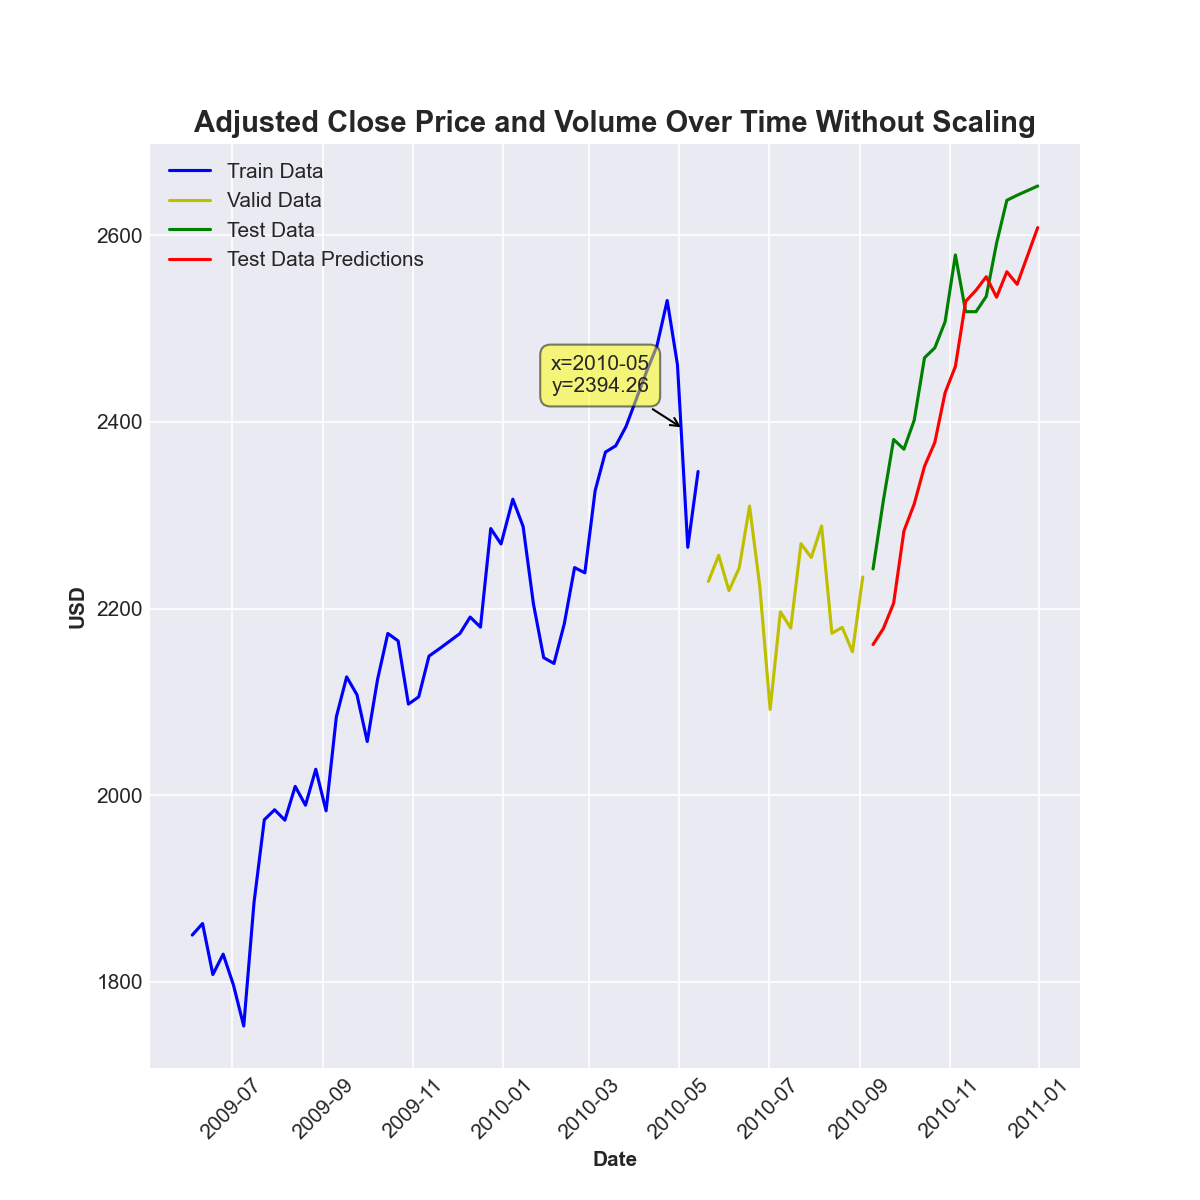

In [106]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_test_df['DATE'], predit_test_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Test Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.xticks(rotation = 45)
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')

mplcursors.cursor(hover = True)

plt.show();

### Conclusion/Analysis

__With the tuned XGBoost, I am still having a difficulty producing accurate predictions. After tuning my Mean Square Error is 64757, and my mean absolute error is 215. I am able to still get some level of a trend, but the accruacy is very low. As my test data showed greater accuracy than my validation set, that confirms the tuning of the model helped in my predictions.__

__Next Stpes__:
    - Change the data that we are feeding into the model for better accuracy. 
        - One of the inconsistencies to fix is taking out the OHLC data that is fed into the model, if we want to only focus on Swine Flu cases and their effect on the stock market. 
    - Use news and twitter sentimental analysis to see how news on Swine Flu can suppliment the analysis and predictions of the machine learning model. 
    - Use hospitilization and death rates along with case count to better account for the devastation Swine Flu.
    - Use 10Q (Quarterly Reports), 10K (Annual Reports), cash flow statements, and any other financial statments to get a better understanding of how the stay at home orders and freeze in the economy has affected companies
    
Although the model is not perfect there is great opportunites for improvement and make it much more accurate. As more data is released to the public over the year, and with other data incorporated into the model, I believe we can be more prepared for future pandemics that come our way.